In [1]:
%load_ext autoreload

import os
import sys
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as pilf
import network_utils as nuts

torch.manual_seed(28)

# OPV NN2

### This notebook to uses OPV processing conditions and summary morphology descriptions to predict device performance.


# Dataset definition

In [6]:
#Take in data as a dataframe for easy preprocessing
train_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_train.xlsx')

test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

total_df = pd.concat([train_df, test_df])

print (f'total_df shape: {total_df.shape}')
print (f'test_df shape: {test_df.shape}')
total_df.head()

total_df shape: (36, 60)
test_df shape: (10, 60)


,Unnamed: 0,p1_fraction,p2_fraction,p3_fraction,p1_area_avg,p1_area_stdev,p1_filled_area_avg,p1_filled_area_stdev,p1_extent_avg,p1_extent_stdev,...,p3_Perim_avg,p3_Perim_stdev,PCE,VocL,Jsc,FF,Substrate,Device,Anneal_time,Anneal_temp
0,0,0.379892,0.741510,0.042227,0.747318,0.416992,0.747056,0.437669,0.371252,0.265335,...,0.385802,0.214615,0.833110,0.817731,0.950302,0.822343,4,2,15,100
1,1,0.299771,0.662438,0.354767,0.338403,0.119074,0.308619,0.108677,0.427280,0.413324,...,0.756401,0.786992,0.635534,0.739614,0.961763,0.685312,4,4,15,100
2,2,0.122273,0.555842,0.907236,0.637064,0.178141,0.581681,0.158955,0.172276,0.278782,...,0.771184,1.000000,0.863038,0.814898,0.947029,0.857800,4,7,15,100
3,3,0.019406,0.848362,0.504491,0.832873,0.498779,0.868876,0.509000,0.240255,0.557641,...,0.557095,0.404926,0.947300,0.806031,0.996387,0.904754,7,2,30,100
4,6,1.000000,0.000000,0.384999,0.271485,0.175114,0.267725,0.171034,0.309962,0.288716,...,0.000000,0.084425,0.865331,0.825047,0.903792,0.890140,1,3,5,100


In [68]:
# Hyper parameters
num_epochs = 500
learning_rate = 1e-6

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [50]:
x_train = total_df.drop(['PCE', 'VocL', 'Jsc', 'FF', 'Unnamed: 0', 'Substrate', 'Device'], axis = 1)#input features used to make prediction
y_train = total_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_test = test_df[['Anneal_time', 'Anneal_temp']]
y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]

# Fit model with variety of learning rates and epochs to find best hyperparameters

In [51]:
%autoreload

def fit(model, lr, epochs):
    
    #define the optimizer
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    
    #empty list to hold loss per epoch
    train_epoch_losses = []
    pce_train_epoch_losses = []
    voc_train_epoch_losses = []
    jsc_train_epoch_losses = []
    ff_train_epoch_losses = []

    test_epoch_losses = []
    pce_test_epoch_losses = []
    voc_test_epoch_losses = []
    jsc_test_epoch_losses = []
    ff_test_epoch_losses = []

    pce_test_epoch_accuracies = []
    voc_test_epoch_accuracies = []
    jsc_test_epoch_accuracies = []
    ff_test_epoch_accuracies = []
    test_epoch_accuracies = []

    pce_test_epoch_r2 = []
    voc_test_epoch_r2 = []
    jsc_test_epoch_r2 = []
    ff_test_epoch_r2 = []
    test_epoch_r2s = []

    save_epochs = np.arange(0, num_epochs, 5)

    for epoch in range(epochs):
        print('On epoch ', epoch)

    #     save_dir = "/Users/wesleytatum/Desktop/model_states/OPV_NN2/"
    #     model_name = "OPV_NN2"
    #     model_path = save_dir+model_name+'*.pt'
    #     if epoch < 10:
    #         save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    #     else:
    #         save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'

    #     if glob.glob(model_path) != []:
    #         model_states = glob.glob(model_path)
    #         model_states = sorted(model_states)
    #         previous_model = model_states[-1]    

    #         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)

        model, train_loss, pce_train_loss, voc_train_loss, jsc_train_loss, ff_train_loss = train.train_OPV_df_model(model = model,                                                                                                     training_data_set = training_data_set,
                                                                                                             optimizer = optimizer)
        train_epoch_losses.append(train_loss)
        pce_train_epoch_losses.append(pce_train_loss)
        voc_train_epoch_losses.append(voc_train_loss)
        jsc_train_epoch_losses.append(jsc_train_loss)
        ff_train_epoch_losses.append(ff_train_loss)

        test_losses, test_accs, test_r2s = test.eval_OPV_df_model(model = model,
                                                                  testing_data_set = testing_data_set)
        pce_test_epoch_losses.append(test_losses[0])
        voc_test_epoch_losses.append(test_losses[1])
        jsc_test_epoch_losses.append(test_losses[2])
        ff_test_epoch_losses.append(test_losses[3])

        tot_tst_loss = sum(test_losses)
        test_epoch_losses.append(tot_tst_loss)

        pce_test_epoch_accuracies.append(test_accs[0])
        voc_test_epoch_accuracies.append(test_accs[1])
        jsc_test_epoch_accuracies.append(test_accs[2])
        ff_test_epoch_accuracies.append(test_accs[3])

        tot_tst_acc = sum(test_accs)
        test_epoch_accuracies.append(tot_tst_acc)

        pce_test_epoch_r2.append(test_r2s[0])
        voc_test_epoch_r2.append(test_r2s[1])
        jsc_test_epoch_r2.append(test_r2s[2])
        ff_test_epoch_r2.append(test_r2s[3])

        tot_tst_r2 = sum(test_r2s)
        test_epoch_r2s.append(tot_tst_r2)

        #nuts.save_trained_model(save_path, epoch, model, optimizer)
        
        print('Finished epoch ', epoch)
        
    best_loss_indx = test_epoch_losses.index(min(test_epoch_losses))
    best_acc_indx = test_epoch_accuracies.index(min(test_epoch_accuracies))
    best_r2_indx = test_epoch_r2s.index(max(test_epoch_r2s))
    
    fit_results = {
        'lr': lr,
        'best_loss_epoch': best_loss_indx,
        'best_acc_epoch': best_acc_indx,
        'best_r2_epoch': best_r2_indx,
        'pce_loss': pce_test_epoch_losses,
        'voc_loss': voc_test_epoch_losses,
        'jsc_loss': jsc_test_epoch_losses,
        'ff_loss': ff_test_epoch_losses,
        'test_losses': test_epoch_losses,        
        'pce_acc': pce_test_epoch_accuracies,
        'voc_acc': voc_test_epoch_accuracies,
        'jsc_acc': jsc_test_epoch_accuracies,
        'ff_acc': ff_test_epoch_accuracies,
        'test_accs': test_epoch_accuracies,
        'pce_r2': pce_test_epoch_r2,
        'voc_r2': voc_test_epoch_r2,
        'jsc_r2': jsc_test_epoch_r2,
        'ff_r2': ff_test_epoch_r2,
        'test_r2s': test_epoch_r2s,
        'train_pce_loss': pce_train_epoch_losses,
        'train_voc_loss': voc_train_epoch_losses,
        'train_jsc_loss': jsc_train_epoch_losses,
        'train_ff_loss': ff_train_epoch_losses
    }

    return fit_results

In [52]:
%autoreload

in_dims = int(x_train.shape[1]) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

In [69]:
%autoreload

cv_fits = {}

kf = KFold(n_splits = 5)

for fold, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
    print(f'Fold # {fold}')
    print('-----------------------------')
    
    train_loader, test_loader = nuts.get_fold_dataloaders_df(x_train, y_train, train_index, test_index)
        
    model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
    model.apply(nuts.init_weights)
    
    cv_fits[fold] = nuts.CV_OPV_fit(model, train_loader, test_loader, lr = learning_rate, epochs = num_epochs)


Fold # 0
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 66.416259765625
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 55.396156311035156
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 47.86339569091797
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 45.55832290649414
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 46.72878646850586
                              Voc = 100.0
                              Jsc = 10

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 44.03520202636719
                              Voc = 69.38874816894531
                              Jsc = 99.83577728271484
                              FF = 46.63259506225586
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 43.03180694580078
                              Voc = 63.56038284301758
                              Jsc = 97.77171325683594
                              FF = 41.002742767333984
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 44.626888275146484
                              Voc = 58.94400405883789
                              Jsc = 97.35261535644531
                              FF = 33.365753173828125
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 45.27760314941406
                              Voc = 55.49647903442383
                              Jsc = 95.8457260131836
                              FF = 32.784645080566406
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 75.90562438964844
                              Voc = 21.1434268951416
                              Jsc = 95.87841033935547
                              FF = 17.120540618896484
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 77.26820373535156
                              Voc = 17.812543869018555
                              Jsc = 95.91107940673828
                              FF = 16.35757064819336
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 76.8387680053711
                              Voc = 14.567737579345703
                              Jsc = 96.29608154296875
                              FF = 16.253522872924805
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 79.39427185058594
                              Voc = 15.392213821411133
                              Jsc = 95.07640838623047
                              FF = 15.5335111618042
Finished epoch  29
On epoch  30
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 85.22382354736328
                              Voc = 11.752686500549316
                              Jsc = 96.48868560791016
                              FF = 16.064390182495117
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE = 86.95897674560547
                              Voc = 12.506973266601562
                              Jsc = 96.30848693847656
                              FF = 16.68940544128418
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 84.09278106689453
                              Voc = 11.91316032409668
                              Jsc = 96.73087310791016
                              FF = 17.489864349365234
Finished epoch  44
On epoch  45
Total Epoch Testing MAPE: PCE = 84.4097900390625
                              Voc = 11.763596534729004
                              Jsc = 96.67642974853516
                              FF = 16.74712371826172
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 85.44239044189453
                              Voc = 12.467856407165527
                              Jsc = 97.46965789794922
                              FF = 15.013996124267578
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 83.90975952148438
                              Voc = 12.779614448547363
                              Jsc = 96.98908233642578
                              FF = 15.03124713897705
Finished epoch  58
On epoch  59
Total Epoch Testing MAPE: PCE = 84.39495086669922
                              Voc = 12.618371963500977
                              Jsc = 96.67350769042969
                              FF = 14.920687675476074
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE = 84.67070007324219
                              Voc = 12.685625076293945
                              Jsc = 97.02278900146484
                              FF = 14.845085144042969
Finished epoch  60
On epoch  61
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 82.78540802001953
                              Voc = 11.451552391052246
                              Jsc = 94.59467315673828
                              FF = 16.55607032775879
Finished epoch  73
On epoch  74
Total Epoch Testing MAPE: PCE = 82.40190887451172
                              Voc = 11.506014823913574
                              Jsc = 94.25677490234375
                              FF = 15.726316452026367
Finished epoch  74
On epoch  75
Total Epoch Testing MAPE: PCE = 84.98030090332031
                              Voc = 11.991720199584961
                              Jsc = 93.76295471191406
                              FF = 16.399059295654297
Finished epoch  75
On epoch  76
Total Epoch Testing MAPE: PCE = 85.47595977783203
                              Voc = 11.57446575164795
                              Jsc = 94.41744232177734
                              FF = 16.131942749023438
Finished epoch  76
On epoch  77
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 80.92042541503906
                              Voc = 12.308910369873047
                              Jsc = 98.15304565429688
                              FF = 16.01709747314453
Finished epoch  87
On epoch  88
Total Epoch Testing MAPE: PCE = 81.31246948242188
                              Voc = 11.76816463470459
                              Jsc = 97.92117309570312
                              FF = 16.138822555541992
Finished epoch  88
On epoch  89
Total Epoch Testing MAPE: PCE = 82.2950668334961
                              Voc = 11.934389114379883
                              Jsc = 97.68140411376953
                              FF = 16.234926223754883
Finished epoch  89
On epoch  90
Total Epoch Testing MAPE: PCE = 84.54139709472656
                              Voc = 11.819377899169922
                              Jsc = 97.31521606445312
                              FF = 15.947857856750488
Finished epoch  90
On epoch  91
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 82.44473266601562
                              Voc = 13.454299926757812
                              Jsc = 94.96278381347656
                              FF = 16.289865493774414
Finished epoch  101
On epoch  102
Total Epoch Testing MAPE: PCE = 84.79803466796875
                              Voc = 14.073875427246094
                              Jsc = 94.74518585205078
                              FF = 15.909777641296387
Finished epoch  102
On epoch  103
Total Epoch Testing MAPE: PCE = 84.90776062011719
                              Voc = 14.170024871826172
                              Jsc = 94.6725082397461
                              FF = 15.469947814941406
Finished epoch  103
On epoch  104
Total Epoch Testing MAPE: PCE = 84.4715576171875
                              Voc = 14.200155258178711
                              Jsc = 94.5435562133789
                              FF = 15.65372085571289
Finished epoch  104
On epoch  105
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 85.57733154296875
                              Voc = 12.929132461547852
                              Jsc = 96.78980255126953
                              FF = 16.943296432495117
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 85.50823974609375
                              Voc = 13.967233657836914
                              Jsc = 96.41429901123047
                              FF = 16.581270217895508
Finished epoch  117
On epoch  118
Total Epoch Testing MAPE: PCE = 85.45390319824219
                              Voc = 14.17357349395752
                              Jsc = 96.39051818847656
                              FF = 17.236909866333008
Finished epoch  118
On epoch  119
Total Epoch Testing MAPE: PCE = 85.08859252929688
                              Voc = 12.85453987121582
                              Jsc = 95.93643188476562
                              FF = 17.046161651611328
Finished epoch  119
On epoch  120
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 82.21267700195312
                              Voc = 11.70694351196289
                              Jsc = 97.16958618164062
                              FF = 15.557321548461914
Finished epoch  131
On epoch  132
Total Epoch Testing MAPE: PCE = 83.75616455078125
                              Voc = 13.086870193481445
                              Jsc = 97.27951049804688
                              FF = 15.693285942077637
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE: PCE = 83.28997802734375
                              Voc = 12.405519485473633
                              Jsc = 97.4868392944336
                              FF = 15.951648712158203
Finished epoch  133
On epoch  134
Total Epoch Testing MAPE: PCE = 83.55401611328125
                              Voc = 13.41385555267334
                              Jsc = 97.63555145263672
                              FF = 15.938896179199219
Finished epoch  134
On epoch  135
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 84.99580383300781
                              Voc = 14.707742691040039
                              Jsc = 97.32591247558594
                              FF = 14.75342845916748
Finished epoch  142
On epoch  143
Total Epoch Testing MAPE: PCE = 82.68302154541016
                              Voc = 14.377776145935059
                              Jsc = 97.61185455322266
                              FF = 14.026151657104492
Finished epoch  143
On epoch  144
Total Epoch Testing MAPE: PCE = 83.50263977050781
                              Voc = 15.083083152770996
                              Jsc = 97.854248046875
                              FF = 13.262128829956055
Finished epoch  144
On epoch  145
Total Epoch Testing MAPE: PCE = 82.41241455078125
                              Voc = 13.117106437683105
                              Jsc = 97.81334686279297
                              FF = 13.074117660522461
Finished epoch  145
On epoch  146
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

151
Total Epoch Testing MAPE: PCE = 82.88484191894531
                              Voc = 16.4891357421875
                              Jsc = 97.146240234375
                              FF = 14.058820724487305
Finished epoch  151
On epoch  152
Total Epoch Testing MAPE: PCE = 83.10073852539062
                              Voc = 16.303709030151367
                              Jsc = 96.93643188476562
                              FF = 13.83236312866211
Finished epoch  152
On epoch  153
Total Epoch Testing MAPE: PCE = 81.15790557861328
                              Voc = 17.076343536376953
                              Jsc = 96.82305145263672
                              FF = 15.196832656860352
Finished epoch  153
On epoch  154
Total Epoch Testing MAPE: PCE = 82.83841705322266
                              Voc = 16.530109405517578
                              Jsc = 96.96434783935547
                              FF = 15.15820598602295
Finished epoch  154
On epoch  155
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 84.98477172851562
                              Voc = 17.460790634155273
                              Jsc = 97.03820037841797
                              FF = 13.737380981445312
Finished epoch  160
On epoch  161
Total Epoch Testing MAPE: PCE = 87.84285736083984
                              Voc = 16.275218963623047
                              Jsc = 96.90164947509766
                              FF = 13.668164253234863
Finished epoch  161
On epoch  162
Total Epoch Testing MAPE: PCE = 87.34510803222656
                              Voc = 16.72930335998535
                              Jsc = 97.13538360595703
                              FF = 13.653712272644043
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 86.75816345214844
                              Voc = 16.41557502746582
                              Jsc = 97.4659652709961
                              FF = 13.896356582641602
Finished epoch  163
On epoch  164
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 86.2625503540039
                              Voc = 16.062225341796875
                              Jsc = 96.90501403808594
                              FF = 13.701531410217285
Finished epoch  169
On epoch  170
Total Epoch Testing MAPE: PCE = 86.09716033935547
                              Voc = 16.931631088256836
                              Jsc = 96.79043579101562
                              FF = 14.259044647216797
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 84.34352111816406
                              Voc = 18.431787490844727
                              Jsc = 96.84166717529297
                              FF = 14.111627578735352
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 86.28955841064453
                              Voc = 20.708675384521484
                              Jsc = 97.4284439086914
                              FF = 14.451873779296875
Finished epoch  172
On epoch  173
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 82.38243103027344
                              Voc = 19.966930389404297
                              Jsc = 96.1455078125
                              FF = 14.248353004455566
Finished epoch  179
On epoch  180
Total Epoch Testing MAPE: PCE = 82.88069152832031
                              Voc = 18.16181182861328
                              Jsc = 96.55602264404297
                              FF = 15.363868713378906
Finished epoch  180
On epoch  181
Total Epoch Testing MAPE: PCE = 83.94969177246094
                              Voc = 18.059406280517578
                              Jsc = 96.29875946044922
                              FF = 15.443218231201172
Finished epoch  181
On epoch  182
Total Epoch Testing MAPE: PCE = 83.12361145019531
                              Voc = 18.06134605407715
                              Jsc = 96.62518310546875
                              FF = 15.597007751464844
Finished epoch  182
On epoch  183
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 81.97673034667969
                              Voc = 16.041824340820312
                              Jsc = 97.4273910522461
                              FF = 16.473913192749023
Finished epoch  191
On epoch  192
Total Epoch Testing MAPE: PCE = 83.29606628417969
                              Voc = 14.577512741088867
                              Jsc = 97.38758087158203
                              FF = 16.5380859375
Finished epoch  192
On epoch  193
Total Epoch Testing MAPE: PCE = 82.43388366699219
                              Voc = 13.987104415893555
                              Jsc = 97.70149993896484
                              FF = 16.189945220947266
Finished epoch  193
On epoch  194
Total Epoch Testing MAPE: PCE = 82.10803985595703
                              Voc = 13.672775268554688
                              Jsc = 97.30201721191406
                              FF = 15.608498573303223
Finished epoch  194
On epoch  195
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 81.4212417602539
                              Voc = 14.091489791870117
                              Jsc = 97.91319274902344
                              FF = 14.82398796081543
Finished epoch  206
On epoch  207
Total Epoch Testing MAPE: PCE = 82.13549041748047
                              Voc = 15.273432731628418
                              Jsc = 97.81502532958984
                              FF = 15.086889266967773
Finished epoch  207
On epoch  208
Total Epoch Testing MAPE: PCE = 82.89390563964844
                              Voc = 14.217403411865234
                              Jsc = 97.78952026367188
                              FF = 15.427106857299805
Finished epoch  208
On epoch  209
Total Epoch Testing MAPE: PCE = 82.3536376953125
                              Voc = 14.177038192749023
                              Jsc = 97.84688568115234
                              FF = 15.650062561035156
Finished epoch  209
On epoch  210
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 83.62834930419922
                              Voc = 15.842448234558105
                              Jsc = 97.55558776855469
                              FF = 17.2627010345459
Finished epoch  221
On epoch  222
Total Epoch Testing MAPE: PCE = 84.09684753417969
                              Voc = 14.339455604553223
                              Jsc = 97.65803527832031
                              FF = 17.642684936523438
Finished epoch  222
On epoch  223
Total Epoch Testing MAPE: PCE = 84.65324401855469
                              Voc = 13.636941909790039
                              Jsc = 97.71591186523438
                              FF = 17.43402862548828
Finished epoch  223
On epoch  224
Total Epoch Testing MAPE: PCE = 83.74712371826172
                              Voc = 15.499259948730469
                              Jsc = 97.74296569824219
                              FF = 17.15115737915039
Finished epoch  224
On epoch  225
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 82.96273040771484
                              Voc = 11.652152061462402
                              Jsc = 97.28430938720703
                              FF = 16.271976470947266
Finished epoch  236
On epoch  237
Total Epoch Testing MAPE: PCE = 83.08687591552734
                              Voc = 11.33139419555664
                              Jsc = 97.54008483886719
                              FF = 16.283802032470703
Finished epoch  237
On epoch  238
Total Epoch Testing MAPE: PCE = 83.87735748291016
                              Voc = 11.207164764404297
                              Jsc = 97.38496398925781
                              FF = 15.130940437316895
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 84.75985717773438
                              Voc = 11.385507583618164
                              Jsc = 97.20997619628906
                              FF = 15.151039123535156
Finished epoch  239
On epoch  240
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 86.52777862548828
                              Voc = 13.921058654785156
                              Jsc = 96.65637969970703
                              FF = 16.2808895111084
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 87.19363403320312
                              Voc = 14.354125022888184
                              Jsc = 96.96892547607422
                              FF = 16.01483154296875
Finished epoch  252
On epoch  253
Total Epoch Testing MAPE: PCE = 84.57256317138672
                              Voc = 14.171266555786133
                              Jsc = 96.94839477539062
                              FF = 15.143205642700195
Finished epoch  253
On epoch  254
Total Epoch Testing MAPE: PCE = 84.36315155029297
                              Voc = 14.117613792419434
                              Jsc = 97.12103271484375
                              FF = 14.718877792358398
Finished epoch  254
On epoch  255
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 83.97367095947266
                              Voc = 11.934089660644531
                              Jsc = 97.77257537841797
                              FF = 15.286734580993652
Finished epoch  266
On epoch  267
Total Epoch Testing MAPE: PCE = 83.30126190185547
                              Voc = 12.15600872039795
                              Jsc = 97.95511627197266
                              FF = 15.387776374816895
Finished epoch  267
On epoch  268
Total Epoch Testing MAPE: PCE = 84.66165161132812
                              Voc = 12.002405166625977
                              Jsc = 97.71944427490234
                              FF = 15.061744689941406
Finished epoch  268
On epoch  269
Total Epoch Testing MAPE: PCE = 85.79566192626953
                              Voc = 11.789016723632812
                              Jsc = 97.34566497802734
                              FF = 15.593537330627441
Finished epoch  269
On epoch  270
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 83.23946380615234
                              Voc = 12.712541580200195
                              Jsc = 96.67835235595703
                              FF = 15.50864028930664
Finished epoch  280
On epoch  281
Total Epoch Testing MAPE: PCE = 84.38848114013672
                              Voc = 12.890450477600098
                              Jsc = 96.36808776855469
                              FF = 14.914751052856445
Finished epoch  281
On epoch  282
Total Epoch Testing MAPE: PCE = 85.15167999267578
                              Voc = 12.719193458557129
                              Jsc = 96.2624282836914
                              FF = 13.900591850280762
Finished epoch  282
On epoch  283
Total Epoch Testing MAPE: PCE = 85.21170043945312
                              Voc = 12.661920547485352
                              Jsc = 96.78043365478516
                              FF = 13.826367378234863
Finished epoch  283
On epoch  284
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 79.50021362304688
                              Voc = 12.886187553405762
                              Jsc = 97.37089538574219
                              FF = 14.2181978225708
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE: PCE = 80.52848815917969
                              Voc = 12.828664779663086
                              Jsc = 97.53376007080078
                              FF = 14.970715522766113
Finished epoch  295
On epoch  296
Total Epoch Testing MAPE: PCE = 80.4277114868164
                              Voc = 13.12157917022705
                              Jsc = 97.54348754882812
                              FF = 14.431962013244629
Finished epoch  296
On epoch  297
Total Epoch Testing MAPE: PCE = 79.31816101074219
                              Voc = 13.214315414428711
                              Jsc = 97.77503967285156
                              FF = 15.341764450073242
Finished epoch  297
On epoch  298
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 84.8427963256836
                              Voc = 12.021666526794434
                              Jsc = 97.4806900024414
                              FF = 15.6857328414917
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 87.66963958740234
                              Voc = 12.092581748962402
                              Jsc = 97.6765365600586
                              FF = 16.05121421813965
Finished epoch  315
On epoch  316
Total Epoch Testing MAPE: PCE = 88.09967041015625
                              Voc = 12.4498929977417
                              Jsc = 97.28276062011719
                              FF = 14.984016418457031
Finished epoch  316
On epoch  317
Total Epoch Testing MAPE: PCE = 87.81908416748047
                              Voc = 12.471988677978516
                              Jsc = 97.2471694946289
                              FF = 15.044135093688965
Finished epoch  317
On epoch  318
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 84.58454895019531
                              Voc = 11.88947868347168
                              Jsc = 97.74442291259766
                              FF = 15.091863632202148
Finished epoch  328
On epoch  329
Total Epoch Testing MAPE: PCE = 83.713623046875
                              Voc = 12.25473690032959
                              Jsc = 97.61309814453125
                              FF = 15.869714736938477
Finished epoch  329
On epoch  330
Total Epoch Testing MAPE: PCE = 84.72904968261719
                              Voc = 11.935233116149902
                              Jsc = 97.38309478759766
                              FF = 15.927555084228516
Finished epoch  330
On epoch  331
Total Epoch Testing MAPE: PCE = 85.47924041748047
                              Voc = 11.941621780395508
                              Jsc = 97.2044677734375
                              FF = 15.222765922546387
Finished epoch  331
On epoch  332
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 81.6240005493164
                              Voc = 17.009632110595703
                              Jsc = 97.55390930175781
                              FF = 15.727252960205078
Finished epoch  342
On epoch  343
Total Epoch Testing MAPE: PCE = 81.74690246582031
                              Voc = 15.938459396362305
                              Jsc = 97.80718231201172
                              FF = 15.411565780639648
Finished epoch  343
On epoch  344
Total Epoch Testing MAPE: PCE = 82.9333267211914
                              Voc = 15.802190780639648
                              Jsc = 97.62516784667969
                              FF = 15.189212799072266
Finished epoch  344
On epoch  345
Total Epoch Testing MAPE: PCE = 82.75611877441406
                              Voc = 16.106718063354492
                              Jsc = 97.41899871826172
                              FF = 15.935598373413086
Finished epoch  345
On epoch  346
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 84.88839721679688
                              Voc = 12.52188491821289
                              Jsc = 97.73786926269531
                              FF = 16.228023529052734
Finished epoch  356
On epoch  357
Total Epoch Testing MAPE: PCE = 85.75640106201172
                              Voc = 13.0418119430542
                              Jsc = 97.73004913330078
                              FF = 16.15360450744629
Finished epoch  357
On epoch  358
Total Epoch Testing MAPE: PCE = 85.62783813476562
                              Voc = 12.480758666992188
                              Jsc = 97.815185546875
                              FF = 16.77464485168457
Finished epoch  358
On epoch  359
Total Epoch Testing MAPE: PCE = 85.40021514892578
                              Voc = 12.183478355407715
                              Jsc = 97.75515747070312
                              FF = 16.452224731445312
Finished epoch  359
On epoch  360
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 78.32243347167969
                              Voc = 12.318536758422852
                              Jsc = 96.92859649658203
                              FF = 15.661531448364258
Finished epoch  370
On epoch  371
Total Epoch Testing MAPE: PCE = 79.37625122070312
                              Voc = 12.61005973815918
                              Jsc = 97.39433288574219
                              FF = 14.90065860748291
Finished epoch  371
On epoch  372
Total Epoch Testing MAPE: PCE = 81.66043090820312
                              Voc = 12.868660926818848
                              Jsc = 97.59358978271484
                              FF = 13.506144523620605
Finished epoch  372
On epoch  373
Total Epoch Testing MAPE: PCE = 80.51749420166016
                              Voc = 14.27268123626709
                              Jsc = 97.42090606689453
                              FF = 14.210997581481934
Finished epoch  373
On epoch  374
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 82.97229766845703
                              Voc = 12.691707611083984
                              Jsc = 96.24369049072266
                              FF = 14.496207237243652
Finished epoch  384
On epoch  385
Total Epoch Testing MAPE: PCE = 84.756103515625
                              Voc = 12.355706214904785
                              Jsc = 96.87459564208984
                              FF = 15.283266067504883
Finished epoch  385
On epoch  386
Total Epoch Testing MAPE: PCE = 84.70420837402344
                              Voc = 12.917876243591309
                              Jsc = 96.88672637939453
                              FF = 15.900167465209961
Finished epoch  386
On epoch  387
Total Epoch Testing MAPE: PCE = 84.13359832763672
                              Voc = 13.541605949401855
                              Jsc = 97.0190200805664
                              FF = 14.940511703491211
Finished epoch  387
On epoch  388
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 81.67581939697266
                              Voc = 12.155251502990723
                              Jsc = 96.77102661132812
                              FF = 15.177353858947754
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 81.51438903808594
                              Voc = 12.343892097473145
                              Jsc = 96.75957489013672
                              FF = 15.228409767150879
Finished epoch  399
On epoch  400
Total Epoch Testing MAPE: PCE = 83.06512451171875
                              Voc = 11.98324966430664
                              Jsc = 96.91638946533203
                              FF = 14.820104598999023
Finished epoch  400
On epoch  401
Total Epoch Testing MAPE: PCE = 82.49414825439453
                              Voc = 11.757901191711426
                              Jsc = 97.19024658203125
                              FF = 14.94714641571045
Finished epoch  401
On epoch  402
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 81.10191345214844
                              Voc = 13.491111755371094
                              Jsc = 96.18106842041016
                              FF = 14.697305679321289
Finished epoch  411
On epoch  412


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 82.94591522216797
                              Voc = 12.018111228942871
                              Jsc = 96.06587982177734
                              FF = 14.423589706420898
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 82.50894165039062
                              Voc = 12.240602493286133
                              Jsc = 96.15711212158203
                              FF = 14.34634017944336
Finished epoch  413
On epoch  414
Total Epoch Testing MAPE: PCE = 84.68680572509766
                              Voc = 12.045523643493652
                              Jsc = 96.09161376953125
                              FF = 14.934857368469238
Finished epoch  414
On epoch  415


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 84.25006866455078
                              Voc = 12.381331443786621
                              Jsc = 96.39849853515625
                              FF = 15.033056259155273
Finished epoch  415
On epoch  416
Total Epoch Testing MAPE: PCE = 84.2584228515625
                              Voc = 13.485713005065918
                              Jsc = 96.53560638427734
                              FF = 15.740182876586914
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 83.67901611328125
                              Voc = 13.103538513183594
                              Jsc = 96.77749633789062
                              FF = 15.814946174621582
Finished epoch  417
On epoch  418
Total Epoch Testing MAPE: PCE = 83.97151947021484
                              Voc = 14.108914375305176
                              Jsc = 96.33367919921875
                              FF = 15.334847450256348
Finished epoch  418
On epoch  419
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 84.92647552490234
                              Voc = 13.851216316223145
                              Jsc = 97.4354248046875
                              FF = 15.06042194366455
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 86.03089904785156
                              Voc = 15.645120620727539
                              Jsc = 97.10044860839844
                              FF = 15.298138618469238
Finished epoch  423
On epoch  424
Total Epoch Testing MAPE: PCE = 84.90636444091797
                              Voc = 15.544137001037598
                              Jsc = 96.85240173339844
                              FF = 14.73110294342041
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 86.77851867675781
                              Voc = 17.375537872314453
                              Jsc = 96.85733032226562
                              FF = 15.662701606750488
Finished epoch  425
On epoch  426
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 87.11212921142578
                              Voc = 17.724035263061523
                              Jsc = 97.0499496459961
                              FF = 16.123899459838867
Finished epoch  435
On epoch  436
Total Epoch Testing MAPE: PCE = 87.33268737792969
                              Voc = 18.813156127929688
                              Jsc = 96.58656311035156
                              FF = 16.737239837646484
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 85.96080780029297
                              Voc = 17.983583450317383
                              Jsc = 96.81095123291016
                              FF = 16.98699378967285
Finished epoch  437
On epoch  438
Total Epoch Testing MAPE: PCE = 84.15106201171875
                              Voc = 17.254295349121094
                              Jsc = 96.86915588378906
                              FF = 17.477890014648438
Finished epoch  438
On epoch  439
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 85.44642639160156
                              Voc = 14.741908073425293
                              Jsc = 97.75255584716797
                              FF = 16.146459579467773
Finished epoch  449
On epoch  450
Total Epoch Testing MAPE: PCE = 82.51304626464844
                              Voc = 15.254727363586426
                              Jsc = 97.8014144897461
                              FF = 15.822129249572754
Finished epoch  450
On epoch  451
Total Epoch Testing MAPE: PCE = 83.84526062011719
                              Voc = 15.660402297973633
                              Jsc = 97.80176544189453
                              FF = 16.304115295410156
Finished epoch  451
On epoch  452
Total Epoch Testing MAPE: PCE = 85.63584899902344
                              Voc = 17.45371437072754
                              Jsc = 97.49554443359375
                              FF = 16.05457305908203
Finished epoch  452
On epoch  453
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 84.02216339111328
                              Voc = 18.715484619140625
                              Jsc = 97.53845977783203
                              FF = 15.246784210205078
Finished epoch  457
On epoch  458
Total Epoch Testing MAPE: PCE = 81.95468139648438
                              Voc = 17.53444480895996
                              Jsc = 97.38431549072266
                              FF = 14.65191650390625
Finished epoch  458
On epoch  459
Total Epoch Testing MAPE: PCE = 82.13357543945312
                              Voc = 18.44743537902832
                              Jsc = 97.298828125
                              FF = 15.40865707397461
Finished epoch  459
On epoch  460
Total Epoch Testing MAPE: PCE = 82.86434173583984
                              Voc = 18.712312698364258
                              Jsc = 96.77928924560547
                              FF = 15.428845405578613
Finished epoch  460
On epoch  461
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 82.6558837890625
                              Voc = 14.003020286560059
                              Jsc = 96.93896484375
                              FF = 14.293699264526367
Finished epoch  469
On epoch  470
Total Epoch Testing MAPE: PCE = 83.12220001220703
                              Voc = 10.949824333190918
                              Jsc = 96.99176025390625
                              FF = 15.335074424743652
Finished epoch  470
On epoch  471
Total Epoch Testing MAPE: PCE = 83.05191040039062
                              Voc = 10.3723783493042
                              Jsc = 96.45858764648438
                              FF = 15.445905685424805
Finished epoch  471
On epoch  472
Total Epoch Testing MAPE: PCE = 83.49322509765625
                              Voc = 10.72513484954834
                              Jsc = 95.99790954589844
                              FF = 15.140785217285156
Finished epoch  472
On epoch  473
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 82.22400665283203
                              Voc = 13.922673225402832
                              Jsc = 96.78266906738281
                              FF = 15.823592185974121
Finished epoch  482
On epoch  483
Total Epoch Testing MAPE: PCE = 81.06490325927734
                              Voc = 13.26625919342041
                              Jsc = 96.97981262207031
                              FF = 15.743239402770996
Finished epoch  483
On epoch  484
Total Epoch Testing MAPE: PCE = 80.94579315185547
                              Voc = 14.718219757080078
                              Jsc = 96.89948272705078
                              FF = 16.018720626831055
Finished epoch  484
On epoch  485
Total Epoch Testing MAPE: PCE = 79.77854919433594
                              Voc = 15.345928192138672
                              Jsc = 97.0881118774414
                              FF = 16.786893844604492
Finished epoch  485
On epoch  486
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 83.38430786132812
                              Voc = 16.620708465576172
                              Jsc = 97.87757873535156
                              FF = 13.920622825622559
Finished epoch  495
On epoch  496
Total Epoch Testing MAPE: PCE = 83.02915954589844
                              Voc = 17.91602325439453
                              Jsc = 97.5295181274414
                              FF = 13.994728088378906
Finished epoch  496
On epoch  497
Total Epoch Testing MAPE: PCE = 83.43090057373047
                              Voc = 17.27887725830078
                              Jsc = 96.79798126220703
                              FF = 13.683950424194336
Finished epoch  497
On epoch  498
Total Epoch Testing MAPE: PCE = 83.14654541015625
                              Voc = 18.59975242614746
                              Jsc = 96.64668273925781
                              FF = 13.477418899536133
Finished epoch  498
On epoch  499
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 60.034549713134766
                              Voc = 144.70843505859375
                              Jsc = 13.069989204406738
                              FF = 5.261505126953125
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 58.151859283447266
                              Voc = 134.72010803222656
                              Jsc = 3.3592371940612793
                              FF = 5.683196544647217
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 57.59648513793945
                              Voc = 123.47325134277344
                              Jsc = 12.765937805175781
                              FF = 6.260250568389893
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 56.65333938598633
                              Voc = 110.93126678466797
                              Jsc = 17.578752517700195
                              FF = 9.187037467956543
Finished epoch  12
On epoch  13
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 57.1881217956543
                              Voc = 70.09815216064453
                              Jsc = 46.65526580810547
                              FF = 14.459864616394043
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 56.3603401184082
                              Voc = 67.20884704589844
                              Jsc = 52.15300369262695
                              FF = 15.713669776916504
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 57.60264587402344
                              Voc = 61.605655670166016
                              Jsc = 56.38618469238281
                              FF = 18.68205451965332
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 55.912078857421875
                              Voc = 56.810707092285156
                              Jsc = 59.01724624633789
                              FF = 18.806610107421875
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 54.801265716552734
                              Voc = 41.8535270690918
                              Jsc = 64.81410217285156
                              FF = 23.526222229003906
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 54.90630340576172
                              Voc = 38.29674530029297
                              Jsc = 67.99417877197266
                              FF = 24.525142669677734
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 55.704254150390625
                              Voc = 33.41009521484375
                              Jsc = 69.59339904785156
                              FF = 25.365665435791016
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 54.38162612915039
                              Voc = 32.347251892089844
                              Jsc = 70.36018371582031
                              FF = 26.564863204956055
Finished epoch  26
On epoch  27
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 52.052528381347656
                              Voc = 27.490785598754883
                              Jsc = 79.14835357666016
                              FF = 28.12783432006836
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 51.9958610534668
                              Voc = 26.95305633544922
                              Jsc = 79.72425842285156
                              FF = 27.60686492919922
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 51.50929641723633
                              Voc = 24.801597595214844
                              Jsc = 79.4370346069336
                              FF = 28.0206298828125
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: PCE = 51.12223815917969
                              Voc = 26.10592269897461
                              Jsc = 80.41473388671875
                              FF = 26.253992080688477
Finished epoch  34
On epoch  35
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

                              Voc = 15.212156295776367
                              Jsc = 81.92755889892578
                              FF = 30.847190856933594
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 53.257896423339844
                              Voc = 14.30677604675293
                              Jsc = 81.75483703613281
                              FF = 31.394094467163086
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 53.135841369628906
                              Voc = 15.439457893371582
                              Jsc = 81.04222869873047
                              FF = 31.25477409362793
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE = 53.20991134643555
                              Voc = 13.390229225158691
                              Jsc = 82.08688354492188
                              FF = 32.10103988647461
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 53.887115478515625
                    

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 52.803688049316406
                              Voc = 14.526542663574219
                              Jsc = 88.6545181274414
                              FF = 32.31913757324219
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 54.364784240722656
                              Voc = 13.484029769897461
                              Jsc = 90.23468780517578
                              FF = 33.956764221191406
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 54.1917610168457
                              Voc = 17.9066104888916
                              Jsc = 89.45686340332031
                              FF = 34.216468811035156
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 53.985923767089844
                              Voc = 18.53955078125
                              Jsc = 89.74757385253906
                              FF = 33.076927185058594
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 53.79964065551758
                              Voc = 9.131537437438965
                              Jsc = 86.68318939208984
                              FF = 31.13465690612793
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 53.39408493041992
                              Voc = 6.948991775512695
                              Jsc = 86.47611999511719
                              FF = 29.724905014038086
Finished epoch  64
On epoch  65
Total Epoch Testing MAPE: PCE = 52.46635055541992
                              Voc = 5.930331707000732
                              Jsc = 86.30180358886719
                              FF = 29.96585464477539
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 51.24264907836914
                              Voc = 5.7735276222229
                              Jsc = 86.09064483642578
                              FF = 29.498586654663086
Finished epoch  66
On epoch  67
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 54.57590866088867
                              Voc = 5.052394866943359
                              Jsc = 85.15323638916016
                              FF = 26.317087173461914
Finished epoch  78
On epoch  79
Total Epoch Testing MAPE: PCE = 55.458003997802734
                              Voc = 5.318227291107178
                              Jsc = 86.20291137695312
                              FF = 28.019908905029297
Finished epoch  79
On epoch  80
Total Epoch Testing MAPE: PCE = 53.81382751464844
                              Voc = 4.817967891693115
                              Jsc = 85.75135803222656
                              FF = 29.252498626708984
Finished epoch  80
On epoch  81
Total Epoch Testing MAPE: PCE = 54.42308044433594
                              Voc = 4.854164123535156
                              Jsc = 86.25045776367188
                              FF = 27.696290969848633
Finished epoch  81
On epoch  82
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 53.42707824707031
                              Voc = 5.01763916015625
                              Jsc = 83.54166412353516
                              FF = 28.43964385986328
Finished epoch  90
On epoch  91
Total Epoch Testing MAPE: PCE = 52.18147659301758
                              Voc = 4.774364948272705
                              Jsc = 84.32308959960938
                              FF = 27.774890899658203
Finished epoch  91
On epoch  92
Total Epoch Testing MAPE: PCE = 52.358863830566406
                              Voc = 5.030820369720459
                              Jsc = 84.62590026855469
                              FF = 29.044559478759766
Finished epoch  92
On epoch  93
Total Epoch Testing MAPE: PCE = 52.10203552246094
                              Voc = 5.527146816253662
                              Jsc = 85.21126556396484
                              FF = 28.102705001831055
Finished epoch  93
On epoch  94
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 52.93416213989258
                              Voc = 8.03640365600586
                              Jsc = 91.85700988769531
                              FF = 26.69283676147461
Finished epoch  104
On epoch  105
Total Epoch Testing MAPE: PCE = 53.29327392578125
                              Voc = 8.265511512756348
                              Jsc = 91.00180053710938
                              FF = 26.94602394104004
Finished epoch  105
On epoch  106
Total Epoch Testing MAPE: PCE = 52.41828155517578
                              Voc = 8.692961692810059
                              Jsc = 91.20320892333984
                              FF = 26.532384872436523
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 50.2326545715332
                              Voc = 9.092912673950195
                              Jsc = 90.85494232177734
                              FF = 26.364269256591797
Finished epoch  107
On epoch  108
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 52.00649642944336
                              Voc = 10.643852233886719
                              Jsc = 84.68836212158203
                              FF = 28.29637908935547
Finished epoch  118
On epoch  119
Total Epoch Testing MAPE: PCE = 54.503787994384766
                              Voc = 10.537619590759277
                              Jsc = 85.49809265136719
                              FF = 29.802248001098633
Finished epoch  119
On epoch  120
Total Epoch Testing MAPE: PCE = 54.697566986083984
                              Voc = 10.400575637817383
                              Jsc = 86.02880096435547
                              FF = 28.230449676513672
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 55.965274810791016
                              Voc = 10.925664901733398
                              Jsc = 87.49726867675781
                              FF = 28.697919845581055
Finished epoch  121
On epoch  122
Total Epoc

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 54.697669982910156
                              Voc = 13.695372581481934
                              Jsc = 84.04125213623047
                              FF = 29.458967208862305
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE: PCE = 54.832489013671875
                              Voc = 13.830465316772461
                              Jsc = 84.15523529052734
                              FF = 29.352781295776367
Finished epoch  133
On epoch  134
Total Epoch Testing MAPE: PCE = 54.97609329223633
                              Voc = 12.812082290649414
                              Jsc = 85.61730194091797
                              FF = 30.97001838684082
Finished epoch  134
On epoch  135
Total Epoch Testing MAPE: PCE = 55.18193817138672
                              Voc = 13.47637939453125
                              Jsc = 85.79277038574219
                              FF = 29.2908935546875
Finished epoch  135
On epoch  136
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 55.74724197387695
                              Voc = 12.161965370178223
                              Jsc = 85.71502685546875
                              FF = 34.34925842285156
Finished epoch  143
On epoch  144
Total Epoch Testing MAPE: PCE = 56.13884353637695
                              Voc = 13.03837776184082
                              Jsc = 84.82591247558594
                              FF = 33.04473876953125
Finished epoch  144
On epoch  145
Total Epoch Testing MAPE: PCE = 55.9581298828125
                              Voc = 12.964816093444824
                              Jsc = 86.06607055664062
                              FF = 33.46046829223633
Finished epoch  145
On epoch  146
Total Epoch Testing MAPE: PCE = 52.92936706542969
                              Voc = 12.302416801452637
                              Jsc = 83.74949645996094
                              FF = 33.43417739868164
Finished epoch  146
On epoch  147
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 51.91006088256836
                              Voc = 14.113612174987793
                              Jsc = 88.84905242919922
                              FF = 30.594310760498047
Finished epoch  156
On epoch  157
Total Epoch Testing MAPE: PCE = 50.47639083862305
                              Voc = 16.03739356994629
                              Jsc = 88.12824249267578
                              FF = 33.011714935302734
Finished epoch  157
On epoch  158
Total Epoch Testing MAPE: PCE = 51.51704406738281
                              Voc = 15.613601684570312
                              Jsc = 88.1707534790039
                              FF = 33.588504791259766
Finished epoch  158
On epoch  159
Total Epoch Testing MAPE: PCE = 50.914363861083984
                              Voc = 14.90058422088623
                              Jsc = 89.24010467529297
                              FF = 32.49320983886719
Finished epoch  159
On epoch  160
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 53.221435546875
                              Voc = 14.983227729797363
                              Jsc = 90.3100814819336
                              FF = 29.135005950927734
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 52.25571823120117
                              Voc = 15.531129837036133
                              Jsc = 89.85741424560547
                              FF = 28.14096450805664
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 51.3213996887207
                              Voc = 16.574249267578125
                              Jsc = 90.28913116455078
                              FF = 29.259910583496094
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 51.448673248291016
                              Voc = 16.45517349243164
                              Jsc = 90.94768524169922
                              FF = 29.06402587890625
Finished epoch  173
On epoch  174
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl


                              Voc = 16.622323989868164
                              Jsc = 89.2897720336914
                              FF = 29.855844497680664
Finished epoch  174
On epoch  175
Total Epoch Testing MAPE: PCE = 51.09062957763672
                              Voc = 16.947011947631836
                              Jsc = 88.87637329101562
                              FF = 29.46892738342285
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 51.2765998840332
                              Voc = 15.93015193939209
                              Jsc = 88.02862548828125
                              FF = 29.04021453857422
Finished epoch  176
On epoch  177
Total Epoch Testing MAPE: PCE = 51.1374397277832
                              Voc = 16.8867130279541
                              Jsc = 88.33793640136719
                              FF = 27.962282180786133
Finished epoch  177
On epoch  178
Total Epoch Testing MAPE: PCE = 50.236480712890625
                  

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 48.36064147949219
                              Voc = 23.985567092895508
                              Jsc = 87.90591430664062
                              FF = 26.70697784423828
Finished epoch  182
On epoch  183
Total Epoch Testing MAPE: PCE = 46.15122604370117
                              Voc = 26.34630584716797
                              Jsc = 88.0576400756836
                              FF = 26.856781005859375
Finished epoch  183
On epoch  184
Total Epoch Testing MAPE: PCE = 47.40098571777344
                              Voc = 27.442724227905273
                              Jsc = 88.97796630859375
                              FF = 26.37680435180664
Finished epoch  184
On epoch  185
Total Epoch Testing MAPE: PCE = 47.502811431884766
                              Voc = 31.68445587158203
                              Jsc = 88.5951156616211
                              FF = 25.905210494995117
Finished epoch  185
On epoch  186
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 46.61594772338867
                              Voc = 30.289844512939453
                              Jsc = 91.61843872070312
                              FF = 29.586347579956055
Finished epoch  192
On epoch  193
Total Epoch Testing MAPE: PCE = 47.25657272338867
                              Voc = 28.08795928955078
                              Jsc = 93.16056060791016
                              FF = 30.024534225463867
Finished epoch  193
On epoch  194
Total Epoch Testing MAPE: PCE = 47.67494201660156
                              Voc = 28.20375633239746
                              Jsc = 93.65805053710938
                              FF = 30.867332458496094
Finished epoch  194
On epoch  195
Total Epoch Testing MAPE: PCE = 48.06809616088867
                              Voc = 26.70513916015625
                              Jsc = 93.1752700805664
                              FF = 33.0762939453125
Finished epoch  195
On epoch  196
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 49.88317108154297
                              Voc = 29.4742488861084
                              Jsc = 88.84725952148438
                              FF = 33.8010368347168
Finished epoch  203
On epoch  204
Total Epoch Testing MAPE: PCE = 49.960941314697266
                              Voc = 31.382274627685547
                              Jsc = 88.84928894042969
                              FF = 33.81485366821289
Finished epoch  204
On epoch  205
Total Epoch Testing MAPE: PCE = 49.25770568847656
                              Voc = 31.3048152923584
                              Jsc = 88.49405670166016
                              FF = 32.861663818359375
Finished epoch  205
On epoch  206
Total Epoch Testing MAPE: PCE = 48.45420455932617
                              Voc = 29.47830581665039
                              Jsc = 88.16400909423828
                              FF = 31.980579376220703
Finished epoch  206
On epoch  207
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 51.858192443847656
                              Voc = 26.075172424316406
                              Jsc = 89.9386978149414
                              FF = 33.7513542175293
Finished epoch  213
On epoch  214
Total Epoch Testing MAPE: PCE = 51.38722610473633
                              Voc = 24.642786026000977
                              Jsc = 88.76839447021484
                              FF = 32.78963851928711
Finished epoch  214
On epoch  215
Total Epoch Testing MAPE: PCE = 51.00885772705078
                              Voc = 25.06049346923828
                              Jsc = 86.56172943115234
                              FF = 33.36821365356445
Finished epoch  215
On epoch  216
Total Epoch Testing MAPE: PCE = 51.274532318115234
                              Voc = 27.075904846191406
                              Jsc = 87.35441589355469
                              FF = 32.017398834228516
Finished epoch  216
On epoch  217
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 52.12641525268555
                              Voc = 32.21424102783203
                              Jsc = 85.78251647949219
                              FF = 30.425983428955078
Finished epoch  219
On epoch  220
Total Epoch Testing MAPE: PCE = 50.507198333740234
                              Voc = 33.1655158996582
                              Jsc = 85.01576232910156
                              FF = 30.935304641723633
Finished epoch  220
On epoch  221
Total Epoch Testing MAPE: PCE = 51.726985931396484
                              Voc = 31.216304779052734
                              Jsc = 86.8231430053711
                              FF = 30.58230209350586
Finished epoch  221
On epoch  222
Total Epoch Testing MAPE: PCE = 50.628108978271484
                              Voc = 28.450315475463867
                              Jsc = 86.54943084716797
                              FF = 30.125125885009766
Finished epoch  222
On epoch  223
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 49.13270950317383
                              Voc = 29.547521591186523
                              Jsc = 86.32402038574219
                              FF = 31.037822723388672
Finished epoch  230
On epoch  231
Total Epoch Testing MAPE: PCE = 51.02669143676758
                              Voc = 31.135377883911133
                              Jsc = 85.83673095703125
                              FF = 28.709020614624023
Finished epoch  231
On epoch  232
Total Epoch Testing MAPE: PCE = 51.10313415527344
                              Voc = 29.42318344116211
                              Jsc = 85.24853515625
                              FF = 28.204423904418945
Finished epoch  232
On epoch  233
Total Epoch Testing MAPE: PCE = 50.46611404418945
                              Voc = 30.27028465270996
                              Jsc = 84.49411010742188
                              FF = 28.31833267211914
Finished epoch  233
On epoch  234
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 51.42093276977539
                              Voc = 29.559589385986328
                              Jsc = 89.16592407226562
                              FF = 29.627138137817383
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 50.25221252441406
                              Voc = 30.677932739257812
                              Jsc = 90.32672882080078
                              FF = 30.999040603637695
Finished epoch  252
On epoch  253
Total Epoch Testing MAPE: PCE = 50.48843765258789
                              Voc = 29.634052276611328
                              Jsc = 89.69462585449219
                              FF = 33.403785705566406
Finished epoch  253
On epoch  254
Total Epoch Testing MAPE: PCE = 48.26908874511719
                              Voc = 32.21236038208008
                              Jsc = 90.73544311523438
                              FF = 33.51786422729492
Finished epoch  254
On epoch  255
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 50.806610107421875
                              Voc = 30.445465087890625
                              Jsc = 91.6829605102539
                              FF = 34.77045440673828
Finished epoch  263
On epoch  264
Total Epoch Testing MAPE: PCE = 50.93934631347656
                              Voc = 31.655078887939453
                              Jsc = 90.06434631347656
                              FF = 35.484745025634766
Finished epoch  264
On epoch  265
Total Epoch Testing MAPE: PCE = 50.42469024658203
                              Voc = 33.124046325683594
                              Jsc = 89.47998046875
                              FF = 35.55241012573242
Finished epoch  265
On epoch  266
Total Epoch Testing MAPE: PCE = 50.31654357910156
                              Voc = 35.377960205078125
                              Jsc = 90.55479431152344
                              FF = 36.249061584472656
Finished epoch  266
On epoch  267
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 48.74310302734375
                              Voc = 33.93848419189453
                              Jsc = 88.85079956054688
                              FF = 33.17687225341797
Finished epoch  276
On epoch  277
Total Epoch Testing MAPE: PCE = 49.29836654663086
                              Voc = 34.291988372802734
                              Jsc = 89.22315979003906
                              FF = 33.14486312866211
Finished epoch  277
On epoch  278
Total Epoch Testing MAPE: PCE = 48.93653869628906
                              Voc = 35.987274169921875
                              Jsc = 89.62391662597656
                              FF = 31.650060653686523
Finished epoch  278
On epoch  279
Total Epoch Testing MAPE: PCE = 49.2923698425293
                              Voc = 36.0389518737793
                              Jsc = 89.76278686523438
                              FF = 31.370445251464844
Finished epoch  279
On epoch  280
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 47.773189544677734
                              Voc = 35.0193977355957
                              Jsc = 90.27064514160156
                              FF = 30.783018112182617
Finished epoch  286
On epoch  287
Total Epoch Testing MAPE: PCE = 47.140384674072266
                              Voc = 32.48115921020508
                              Jsc = 89.78775787353516
                              FF = 32.065589904785156
Finished epoch  287
On epoch  288
Total Epoch Testing MAPE: PCE = 45.180442810058594
                              Voc = 33.21097946166992
                              Jsc = 87.86433410644531
                              FF = 31.381839752197266
Finished epoch  288
On epoch  289
Total Epoch Testing MAPE: PCE = 48.03512954711914
                              Voc = 33.67850112915039
                              Jsc = 87.74019622802734
                              FF = 31.281524658203125
Finished epoch  289
On epoch  290
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 49.07509231567383
                              Voc = 34.695762634277344
                              Jsc = 89.07798767089844
                              FF = 30.4691162109375
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE: PCE = 47.99119567871094
                              Voc = 33.164756774902344
                              Jsc = 87.56893157958984
                              FF = 31.09796142578125
Finished epoch  295
On epoch  296
Total Epoch Testing MAPE: PCE = 48.551937103271484
                              Voc = 32.410400390625
                              Jsc = 85.39253234863281
                              FF = 31.236549377441406
Finished epoch  296
On epoch  297
Total Epoch Testing MAPE: PCE = 47.55635070800781
                              Voc = 32.99427032470703
                              Jsc = 85.72480010986328
                              FF = 31.09380340576172
Finished epoch  297
On epoch  298
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 52.3454475402832
                              Voc = 30.268733978271484
                              Jsc = 86.3974609375
                              FF = 31.24353790283203
Finished epoch  306
On epoch  307
Total Epoch Testing MAPE: PCE = 51.94536590576172
                              Voc = 29.6899356842041
                              Jsc = 86.91951751708984
                              FF = 30.75527572631836
Finished epoch  307
On epoch  308
Total Epoch Testing MAPE: PCE = 52.05098342895508
                              Voc = 29.383281707763672
                              Jsc = 90.1693344116211
                              FF = 31.279420852661133
Finished epoch  308
On epoch  309
Total Epoch Testing MAPE: PCE = 49.88125991821289
                              Voc = 28.568622589111328
                              Jsc = 90.09752655029297
                              FF = 30.16887664794922
Finished epoch  309
On epoch  310
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 52.40336608886719
                              Voc = 25.80180549621582
                              Jsc = 91.7718505859375
                              FF = 29.22739601135254
Finished epoch  318
On epoch  319
Total Epoch Testing MAPE: PCE = 50.013362884521484
                              Voc = 24.884929656982422
                              Jsc = 89.78485107421875
                              FF = 29.121524810791016
Finished epoch  319
On epoch  320
Total Epoch Testing MAPE: PCE = 49.5010986328125
                              Voc = 26.494583129882812
                              Jsc = 89.91073608398438
                              FF = 27.835237503051758
Finished epoch  320
On epoch  321
Total Epoch Testing MAPE: PCE = 48.85637283325195
                              Voc = 27.275657653808594
                              Jsc = 90.43509674072266
                              FF = 28.11184310913086
Finished epoch  321
On epoch  322
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 46.9705924987793
                              Voc = 25.27293586730957
                              Jsc = 90.29591369628906
                              FF = 28.871503829956055
Finished epoch  331
On epoch  332
Total Epoch Testing MAPE: PCE = 47.046512603759766
                              Voc = 26.298606872558594
                              Jsc = 89.5206298828125
                              FF = 28.174686431884766
Finished epoch  332
On epoch  333
Total Epoch Testing MAPE: PCE = 46.3209342956543
                              Voc = 26.47454071044922
                              Jsc = 89.33332824707031
                              FF = 28.19268798828125
Finished epoch  333
On epoch  334
Total Epoch Testing MAPE: PCE = 46.84254837036133
                              Voc = 24.567874908447266
                              Jsc = 89.41744232177734
                              FF = 28.652402877807617
Finished epoch  334
On epoch  335
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 47.2684440612793
                              Voc = 25.880983352661133
                              Jsc = 88.66327667236328
                              FF = 30.118045806884766
Finished epoch  343
On epoch  344
Total Epoch Testing MAPE: PCE = 46.49542999267578
                              Voc = 24.75729751586914
                              Jsc = 89.36566925048828
                              FF = 30.970829010009766
Finished epoch  344
On epoch  345
Total Epoch Testing MAPE: PCE = 45.98774719238281
                              Voc = 24.160606384277344
                              Jsc = 91.91487121582031
                              FF = 31.427431106567383
Finished epoch  345
On epoch  346
Total Epoch Testing MAPE: PCE = 46.0325813293457
                              Voc = 23.802852630615234
                              Jsc = 90.88249206542969
                              FF = 30.831876754760742
Finished epoch  346
On epoch  347
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 50.97345733642578
                              Voc = 22.621583938598633
                              Jsc = 88.82603454589844
                              FF = 29.527191162109375
Finished epoch  355
On epoch  356
Total Epoch Testing MAPE: PCE = 50.08040237426758
                              Voc = 24.564756393432617
                              Jsc = 88.0853500366211
                              FF = 28.670242309570312
Finished epoch  356
On epoch  357
Total Epoch Testing MAPE: PCE = 49.77958679199219
                              Voc = 22.85576057434082
                              Jsc = 87.63194274902344
                              FF = 28.437450408935547
Finished epoch  357
On epoch  358
Total Epoch Testing MAPE: PCE = 50.94521713256836
                              Voc = 27.258256912231445
                              Jsc = 87.54032897949219
                              FF = 29.439958572387695
Finished epoch  358
On epoch  359
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 48.4234733581543
                              Voc = 27.607282638549805
                              Jsc = 86.6873550415039
                              FF = 27.622095108032227
Finished epoch  368
On epoch  369
Total Epoch Testing MAPE: PCE = 49.07661437988281
                              Voc = 26.776334762573242
                              Jsc = 88.00513458251953
                              FF = 28.270050048828125
Finished epoch  369
On epoch  370
Total Epoch Testing MAPE: PCE = 49.26477813720703
                              Voc = 28.141822814941406
                              Jsc = 88.69712829589844
                              FF = 28.086814880371094
Finished epoch  370
On epoch  371
Total Epoch Testing MAPE: PCE = 50.75644302368164
                              Voc = 27.712940216064453
                              Jsc = 89.06649017333984
                              FF = 27.448997497558594
Finished epoch  371
On epoch  372
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 49.71759796142578
                              Voc = 28.66461944580078
                              Jsc = 92.39369201660156
                              FF = 28.189117431640625
Finished epoch  382
On epoch  383
Total Epoch Testing MAPE: PCE = 50.89188766479492
                              Voc = 26.069265365600586
                              Jsc = 94.74899291992188
                              FF = 29.10913848876953
Finished epoch  383
On epoch  384
Total Epoch Testing MAPE: PCE = 51.017032623291016
                              Voc = 25.75424575805664
                              Jsc = 94.51838684082031
                              FF = 29.64213752746582
Finished epoch  384
On epoch  385
Total Epoch Testing MAPE: PCE = 50.86210250854492
                              Voc = 24.73814582824707
                              Jsc = 94.0184097290039
                              FF = 30.602582931518555
Finished epoch  385
On epoch  386
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 48.611698150634766
                              Voc = 21.161161422729492
                              Jsc = 91.70808410644531
                              FF = 33.19975662231445
Finished epoch  396
On epoch  397
Total Epoch Testing MAPE: PCE = 47.73910903930664
                              Voc = 18.53523063659668
                              Jsc = 91.55571746826172
                              FF = 32.10363006591797
Finished epoch  397
On epoch  398
Total Epoch Testing MAPE: PCE = 47.80815124511719
                              Voc = 19.80878257751465
                              Jsc = 91.76692962646484
                              FF = 33.637603759765625
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 48.33767318725586
                              Voc = 18.41329002380371
                              Jsc = 91.77140045166016
                              FF = 33.826717376708984
Finished epoch  399
On epoch  400
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 48.468997955322266
                              Voc = 18.825037002563477
                              Jsc = 92.34126281738281
                              FF = 35.55778503417969
Finished epoch  407
On epoch  408
Total Epoch Testing MAPE: PCE = 48.5604362487793
                              Voc = 17.01363754272461
                              Jsc = 92.07524871826172
                              FF = 34.46818161010742
Finished epoch  408
On epoch  409
Total Epoch Testing MAPE: PCE = 47.8197021484375
                              Voc = 15.659393310546875
                              Jsc = 91.52584838867188
                              FF = 34.466487884521484
Finished epoch  409
On epoch  410
Total Epoch Testing MAPE: PCE = 47.5487174987793
                              Voc = 16.274341583251953
                              Jsc = 90.36476135253906
                              FF = 35.60728073120117
Finished epoch  410
On epoch  411
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 50.70411682128906
                              Voc = 19.491580963134766
                              Jsc = 90.37403106689453
                              FF = 36.59367370605469
Finished epoch  420
On epoch  421
Total Epoch Testing MAPE: PCE = 52.626426696777344
                              Voc = 17.290916442871094
                              Jsc = 89.50940704345703
                              FF = 37.072486877441406
Finished epoch  421
On epoch  422
Total Epoch Testing MAPE: PCE = 52.85495376586914
                              Voc = 18.4989070892334
                              Jsc = 90.2530517578125
                              FF = 36.63066482543945
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 53.688716888427734
                              Voc = 21.22591209411621
                              Jsc = 89.2315902709961
                              FF = 37.479454040527344
Finished epoch  423
On epoch  424
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

                              Voc = 20.450332641601562
                              Jsc = 87.26165771484375
                              FF = 33.68772888183594
Finished epoch  430
On epoch  431
Total Epoch Testing MAPE: PCE = 54.109012603759766
                              Voc = 20.2860050201416
                              Jsc = 88.0033950805664
                              FF = 35.070098876953125
Finished epoch  431
On epoch  432
Total Epoch Testing MAPE: PCE = 52.91358184814453
                              Voc = 22.050823211669922
                              Jsc = 89.57167053222656
                              FF = 33.65593719482422
Finished epoch  432
On epoch  433
Total Epoch Testing MAPE: PCE = 54.35659408569336
                              Voc = 22.621522903442383
                              Jsc = 91.65560150146484
                              FF = 32.61441421508789
Finished epoch  433
On epoch  434
Total Epoch Testing MAPE: PCE = 53.708351135253906
                

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 56.0107421875
                              Voc = 23.944374084472656
                              Jsc = 89.45105743408203
                              FF = 33.15078353881836
Finished epoch  439
On epoch  440
Total Epoch Testing MAPE: PCE = 57.245689392089844
                              Voc = 21.41257667541504
                              Jsc = 90.12942504882812
                              FF = 31.40740966796875
Finished epoch  440
On epoch  441
Total Epoch Testing MAPE: PCE = 57.2108268737793
                              Voc = 22.51288414001465
                              Jsc = 89.10202026367188
                              FF = 31.87592315673828
Finished epoch  441
On epoch  442
Total Epoch Testing MAPE: PCE = 56.11587142944336
                              Voc = 22.095745086669922
                              Jsc = 89.32011413574219
                              FF = 31.969186782836914
Finished epoch  442
On epoch  443
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 49.18232727050781
                              Voc = 17.469663619995117
                              Jsc = 84.44032287597656
                              FF = 32.33474349975586
Finished epoch  451
On epoch  452
Total Epoch Testing MAPE: PCE = 49.32886505126953
                              Voc = 17.458843231201172
                              Jsc = 85.78394317626953
                              FF = 29.91632843017578
Finished epoch  452
On epoch  453
Total Epoch Testing MAPE: PCE = 49.68048095703125
                              Voc = 17.541669845581055
                              Jsc = 86.27458953857422
                              FF = 29.7489013671875
Finished epoch  453
On epoch  454
Total Epoch Testing MAPE: PCE = 48.82844924926758
                              Voc = 17.455127716064453
                              Jsc = 87.00846099853516
                              FF = 30.14786148071289
Finished epoch  454
On epoch  455
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 47.43387985229492
                              Voc = 18.770347595214844
                              Jsc = 92.14698028564453
                              FF = 30.317861557006836
Finished epoch  464
On epoch  465
Total Epoch Testing MAPE: PCE = 48.05105209350586
                              Voc = 18.624881744384766
                              Jsc = 91.13969421386719
                              FF = 30.049875259399414
Finished epoch  465
On epoch  466
Total Epoch Testing MAPE: PCE = 47.53728103637695
                              Voc = 19.67844009399414
                              Jsc = 91.11334228515625
                              FF = 30.479446411132812
Finished epoch  466
On epoch  467
Total Epoch Testing MAPE: PCE = 45.24835968017578
                              Voc = 21.27277183532715
                              Jsc = 90.5455093383789
                              FF = 32.395751953125
Finished epoch  467
On epoch  468
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 49.00133514404297
                              Voc = 15.546183586120605
                              Jsc = 93.98179626464844
                              FF = 33.156673431396484
Finished epoch  478
On epoch  479
Total Epoch Testing MAPE: PCE = 49.89518737792969
                              Voc = 13.684887886047363
                              Jsc = 92.29882049560547
                              FF = 33.97278594970703
Finished epoch  479
On epoch  480
Total Epoch Testing MAPE: PCE = 49.986900329589844
                              Voc = 12.608613014221191
                              Jsc = 91.61595153808594
                              FF = 34.28733825683594
Finished epoch  480
On epoch  481
Total Epoch Testing MAPE: PCE = 49.057437896728516
                              Voc = 12.450995445251465
                              Jsc = 90.8530044555664
                              FF = 34.25899887084961
Finished epoch  481
On epoch  482
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 49.093990325927734
                              Voc = 18.063570022583008
                              Jsc = 92.47029113769531
                              FF = 29.09093475341797
Finished epoch  491
On epoch  492
Total Epoch Testing MAPE: PCE = 49.6058235168457
                              Voc = 20.3726863861084
                              Jsc = 90.39381408691406
                              FF = 30.437332153320312
Finished epoch  492
On epoch  493
Total Epoch Testing MAPE: PCE = 50.13579559326172
                              Voc = 20.30866241455078
                              Jsc = 90.84539794921875
                              FF = 30.957826614379883
Finished epoch  493
On epoch  494
Total Epoch Testing MAPE: PCE = 51.6013069152832
                              Voc = 19.3160400390625
                              Jsc = 89.28502655029297
                              FF = 30.46803092956543
Finished epoch  494
On epoch  495
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 50.55788803100586
                              Voc = 15.347509384155273
                              Jsc = 90.31525421142578
                              FF = 32.15681457519531
Finished epoch  498
On epoch  499
Total Epoch Testing MAPE: PCE = 49.661888122558594
                              Voc = 15.294466972351074
                              Jsc = 89.67776489257812
                              FF = 32.17655563354492
Finished epoch  499
Fold # 2
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 43263.625
                              Voc = 42898.9921875
                              Jsc = nan
                              FF = nan
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 43187.21484375
                              Voc = 42894.9140625
                              Jsc = nan
                              FF = nan
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 43129.72265625
                

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42963.36328125
                              Voc = 42875.82421875
                              Jsc = nan
                              FF = nan
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 42956.37109375
                              Voc = 42875.5546875
                              Jsc = nan
                              FF = nan
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 42945.2890625
                              Voc = 42872.5234375
                              Jsc = nan
                              FF = 42914.28125
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 42936.5078125
                              Voc = 42873.7890625
                              Jsc = nan
                              FF = 42914.28125
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 42932.1484375
                              Voc = 42872.0625
                              Jsc = nan
                    

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42907.53515625
                              Voc = 42867.6484375
                              Jsc = nan
                              FF = 42909.21484375
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 42906.3046875
                              Voc = 42867.5546875
                              Jsc = nan
                              FF = 42909.3203125
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 42904.92578125
                              Voc = 42867.65234375
                              Jsc = nan
                              FF = 42908.34765625
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 42903.5
                              Voc = 42867.79296875
                              Jsc = nan
                              FF = 42907.72265625
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 42904.3046875
                              Voc = 42867.62890625
                              Jsc 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42894.3828125
                              Voc = 42867.55859375
                              Jsc = nan
                              FF = 42906.7578125
Finished epoch  36
On epoch  37
Total Epoch Testing MAPE: PCE = 42895.27734375
                              Voc = 42867.65625
                              Jsc = nan
                              FF = 42907.45703125
Finished epoch  37
On epoch  38
Total Epoch Testing MAPE: PCE = 42895.4140625
                              Voc = 42867.65625
                              Jsc = nan
                              FF = 42907.6640625
Finished epoch  38
On epoch  39
Total Epoch Testing MAPE: PCE = 42895.75
                              Voc = 42867.6015625
                              Jsc = nan
                              FF = 42907.125
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 42895.75
                              Voc = 42867.58203125
                              Jsc = nan
          

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42889.796875
                              Voc = 42867.9375
                              Jsc = nan
                              FF = 42906.8359375
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 42890.2578125
                              Voc = 42867.1953125
                              Jsc = nan
                              FF = 42907.25
Finished epoch  44
On epoch  45
Total Epoch Testing MAPE: PCE = 42888.45703125
                              Voc = 42867.1328125
                              Jsc = nan
                              FF = 42907.00390625
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE: PCE = 42889.30078125
                              Voc = 42867.265625
                              Jsc = nan
                              FF = 42906.95703125
Finished epoch  46
On epoch  47


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 42889.1328125
                              Voc = 42867.4296875
                              Jsc = nan
                              FF = 42906.60546875
Finished epoch  47
On epoch  48


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 42889.10546875
                              Voc = 42867.14453125
                              Jsc = nan
                              FF = 42906.62109375
Finished epoch  48
On epoch  49


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 42888.203125
                              Voc = 42867.30859375
                              Jsc = nan
                              FF = 42906.56640625
Finished epoch  49
On epoch  50
Total Epoch Testing MAPE: PCE = 42888.11328125
                              Voc = 42867.75
                              Jsc = nan
                              FF = 42906.2578125
Finished epoch  50
On epoch  51
Total Epoch Testing MAPE: PCE = 42886.6796875
                              Voc = 42868.46484375
                              Jsc = nan
                              FF = 42906.0234375
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 42886.84375
                              Voc = 42867.5
                              Jsc = nan
                              FF = 42905.41796875
Finished epoch  52
On epoch  53


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42887.546875
                              Voc = 42867.50390625
                              Jsc = nan
                              FF = 42904.83984375
Finished epoch  53
On epoch  54


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 42887.30078125
                              Voc = 42869.92578125
                              Jsc = nan
                              FF = 42905.01171875
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE: PCE = 42886.52734375
                              Voc = 42868.91015625
                              Jsc = nan
                              FF = 42905.83203125
Finished epoch  55
On epoch  56
Total Epoch Testing MAPE: PCE = 42886.55859375
                              Voc = 42867.46484375
                              Jsc = nan
                              FF = 42906.2421875
Finished epoch  56
On epoch  57


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42886.05859375
                              Voc = 42867.234375
                              Jsc = nan
                              FF = 42905.71484375
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 42886.546875
                              Voc = 42866.62109375
                              Jsc = nan
                              FF = 42905.5390625
Finished epoch  58
On epoch  59
Total Epoch Testing MAPE: PCE = 42886.80859375
                              Voc = 42866.38671875
                              Jsc = nan
                              FF = 42906.6328125
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE = 42886.41015625
                              Voc = 42866.2578125
                              Jsc = nan
                              FF = 42906.73046875
Finished epoch  60
On epoch  61
Total Epoch Testing MAPE: PCE = 42887.0078125
                              Voc = 42866.16015625
                              

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42889.9375
                              Voc = 42866.16015625
                              Jsc = nan
                              FF = 42904.26171875
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE: PCE = 42891.84375
                              Voc = 42866.3125
                              Jsc = nan
                              FF = 42904.09375
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 42889.2578125
                              Voc = 42866.0390625
                              Jsc = nan
                              FF = 42904.12109375
Finished epoch  73
On epoch  74
Total Epoch Testing MAPE: PCE = 42889.94140625
                              Voc = 42865.828125
                              Jsc = nan
                              FF = 42903.9453125
Finished epoch  74
On epoch  75
Total Epoch Testing MAPE: PCE = 42889.46875
                              Voc = 42865.703125
                              Jsc = nan
      

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42889.75390625
                              Voc = 42871.13671875
                              Jsc = nan
                              FF = 42903.546875
Finished epoch  82
On epoch  83
Total Epoch Testing MAPE: PCE = 42889.30859375
                              Voc = 42871.6328125
                              Jsc = nan
                              FF = 42903.8828125
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 42888.2734375
                              Voc = 42869.4140625
                              Jsc = nan
                              FF = 42904.1953125
Finished epoch  84
On epoch  85
Total Epoch Testing MAPE: PCE = 42886.86328125
                              Voc = 42870.96875
                              Jsc = nan
                              FF = 42904.8359375
Finished epoch  85
On epoch  86
Total Epoch Testing MAPE: PCE = 42886.6484375
                              Voc = 42873.34765625
                              Jsc 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42886.6796875
                              Voc = 42867.921875
                              Jsc = nan
                              FF = 42903.4453125
Finished epoch  95
On epoch  96
Total Epoch Testing MAPE: PCE = 42886.30078125
                              Voc = 42866.80078125
                              Jsc = nan
                              FF = 42903.41015625
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 42887.03125
                              Voc = 42867.33984375
                              Jsc = nan
                              FF = 42904.08203125
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 42886.83203125
                              Voc = 42868.125
                              Jsc = nan
                              FF = 42904.79296875
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE = 42886.46484375
                              Voc = 42868.72265625
                              Jsc 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42889.046875
                              Voc = 42865.6640625
                              Jsc = nan
                              FF = 42905.21484375
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 42889.45703125
                              Voc = 42865.71875
                              Jsc = nan
                              FF = 42905.2578125
Finished epoch  107
On epoch  108
Total Epoch Testing MAPE: PCE = 42889.15625
                              Voc = 42865.90234375
                              Jsc = nan
                              FF = 42904.80078125
Finished epoch  108
On epoch  109
Total Epoch Testing MAPE: PCE = 42888.03125
                              Voc = 42865.96484375
                              Jsc = nan
                              FF = 42905.4765625
Finished epoch  109
On epoch  110
Total Epoch Testing MAPE: PCE = 42888.6640625
                              Voc = 42865.8828125
                              

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42887.18359375
                              Voc = 42865.9375
                              Jsc = nan
                              FF = 42903.88671875
Finished epoch  118
On epoch  119
Total Epoch Testing MAPE: PCE = 42888.6796875
                              Voc = 42865.875
                              Jsc = nan
                              FF = 42904.3046875
Finished epoch  119
On epoch  120
Total Epoch Testing MAPE: PCE = 42887.73828125
                              Voc = 42865.96875
                              Jsc = nan
                              FF = 42904.83203125
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 42887.3125
                              Voc = 42865.92578125
                              Jsc = nan
                              FF = 42904.59765625
Finished epoch  121
On epoch  122
Total Epoch Testing MAPE: PCE = 42888.5234375
                              Voc = 42866.0390625
                              Jsc 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42887.8984375
                              Voc = 42865.53515625
                              Jsc = nan
                              FF = 42906.8203125
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE: PCE = 42886.6796875
                              Voc = 42865.640625
                              Jsc = nan
                              FF = 42907.13671875
Finished epoch  133
On epoch  134
Total Epoch Testing MAPE: PCE = 42887.5078125
                              Voc = 42865.60546875
                              Jsc = nan
                              FF = 42906.80078125
Finished epoch  134
On epoch  135
Total Epoch Testing MAPE: PCE = 42887.26171875
                              Voc = 42865.58984375
                              Jsc = nan
                              FF = 42907.109375
Finished epoch  135
On epoch  136
Total Epoch Testing MAPE: PCE = 42889.21484375
                              Voc = 42865.453125
                        

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42887.36328125
                              Voc = 42865.44921875
                              Jsc = nan
                              FF = 42906.6015625
Finished epoch  146
On epoch  147
Total Epoch Testing MAPE: PCE = 42885.984375
                              Voc = 42865.62109375
                              Jsc = nan
                              FF = 42906.2421875
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 42886.1796875
                              Voc = 42865.62109375
                              Jsc = nan
                              FF = 42906.2421875
Finished epoch  148
On epoch  149
Total Epoch Testing MAPE: PCE = 42885.953125
                              Voc = 42865.640625
                              Jsc = nan
                              FF = 42906.51953125
Finished epoch  149
On epoch  150
Total Epoch Testing MAPE: PCE = 42887.5078125
                              Voc = 42865.4453125
                          

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42886.234375
                              Voc = 42865.578125
                              Jsc = nan
                              FF = 42905.9609375
Finished epoch  159
On epoch  160
Total Epoch Testing MAPE: PCE = 42886.2109375
                              Voc = 42865.578125
                              Jsc = nan
                              FF = 42906.23046875
Finished epoch  160
On epoch  161
Total Epoch Testing MAPE: PCE = 42886.02734375
                              Voc = 42865.6015625
                              Jsc = nan
                              FF = 42907.27734375
Finished epoch  161
On epoch  162
Total Epoch Testing MAPE: PCE = 42886.015625
                              Voc = 42865.640625
                              Jsc = nan
                              FF = 42907.44140625
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 42885.54296875
                              Voc = 42865.671875
                             

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42886.0546875
                              Voc = 42864.796875
                              Jsc = nan
                              FF = 42905.68359375
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 42886.08203125
                              Voc = 42864.83984375
                              Jsc = nan
                              FF = 42906.2890625
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 42885.89453125
                              Voc = 42864.640625
                              Jsc = nan
                              FF = 42906.34765625
Finished epoch  173
On epoch  174
Total Epoch Testing MAPE: PCE = 42886.109375
                              Voc = 42864.80859375
                              Jsc = nan
                              FF = 42906.0234375
Finished epoch  174
On epoch  175
Total Epoch Testing MAPE: PCE = 42885.63671875
                              Voc = 42865.01171875
                       

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42887.0546875
                              Voc = 42865.421875
                              Jsc = nan
                              FF = 42903.9453125
Finished epoch  185
On epoch  186
Total Epoch Testing MAPE: PCE = 42887.58203125
                              Voc = 42865.60546875
                              Jsc = nan
                              FF = 42904.18359375
Finished epoch  186
On epoch  187
Total Epoch Testing MAPE: PCE = 42886.15234375
                              Voc = 42865.6328125
                              Jsc = nan
                              FF = 42905.0078125
Finished epoch  187
On epoch  188
Total Epoch Testing MAPE: PCE = 42885.44140625
                              Voc = 42865.55859375
                              Jsc = nan
                              FF = 42905.29296875
Finished epoch  188
On epoch  189
Total Epoch Testing MAPE: PCE = 42885.56640625
                              Voc = 42865.62109375
                    

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42885.06640625
                              Voc = 42865.37109375
                              Jsc = nan
                              FF = 42905.4609375
Finished epoch  199
On epoch  200
Total Epoch Testing MAPE: PCE = 42885.56640625
                              Voc = 42865.37109375
                              Jsc = nan
                              FF = 42905.7421875
Finished epoch  200
On epoch  201
Total Epoch Testing MAPE: PCE = 42886.42578125
                              Voc = 42865.44921875
                              Jsc = nan
                              FF = 42905.984375
Finished epoch  201
On epoch  202
Total Epoch Testing MAPE: PCE = 42886.44140625
                              Voc = 42865.484375
                              Jsc = nan
                              FF = 42905.7109375
Finished epoch  202
On epoch  203
Total Epoch Testing MAPE: PCE = 42887.66015625
                              Voc = 42865.74609375
                     

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42887.46484375
                              Voc = 42865.4140625
                              Jsc = nan
                              FF = 42904.96484375
Finished epoch  212
On epoch  213
Total Epoch Testing MAPE: PCE = 42888.7265625
                              Voc = 42865.3671875
                              Jsc = nan
                              FF = 42905.0390625
Finished epoch  213
On epoch  214
Total Epoch Testing MAPE: PCE = 42887.3046875
                              Voc = 42865.4765625
                              Jsc = nan
                              FF = 42905.28125
Finished epoch  214
On epoch  215
Total Epoch Testing MAPE: PCE = 42886.1796875
                              Voc = 42865.41015625
                              Jsc = nan
                              FF = 42905.12890625
Finished epoch  215
On epoch  216
Total Epoch Testing MAPE: PCE = 42886.015625
                              Voc = 42865.4296875
                           

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42884.30078125
                              Voc = 42865.578125
                              Jsc = nan
                              FF = 42906.1796875
Finished epoch  235
On epoch  236
Total Epoch Testing MAPE: PCE = 42883.75
                              Voc = 42865.65234375
                              Jsc = nan
                              FF = 42905.94921875
Finished epoch  236
On epoch  237
Total Epoch Testing MAPE: PCE = 42883.296875
                              Voc = 42865.44921875
                              Jsc = nan
                              FF = 42906.34765625
Finished epoch  237
On epoch  238
Total Epoch Testing MAPE: PCE = 42883.53515625
                              Voc = 42865.3125
                              Jsc = nan
                              FF = 42906.41015625
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 42883.3671875
                              Voc = 42865.10546875
                              

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42885.21484375
                              Voc = 42865.07421875
                              Jsc = 42882.37890625
                              FF = 42904.8359375
Finished epoch  248
On epoch  249
Total Epoch Testing MAPE: PCE = 42885.23046875
                              Voc = 42864.97265625
                              Jsc = 42883.15625
                              FF = 42904.4453125
Finished epoch  249
On epoch  250
Total Epoch Testing MAPE: PCE = 42885.0390625
                              Voc = 42864.828125
                              Jsc = nan
                              FF = 42904.15234375
Finished epoch  250
On epoch  251
Total Epoch Testing MAPE: PCE = 42885.30859375
                              Voc = 42864.921875
                              Jsc = 42882.0234375
                              FF = 42904.34765625
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 42885.46875
                              Voc = 42864.8515

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42885.95703125
                              Voc = 42864.66796875
                              Jsc = 42879.625
                              FF = 42903.765625
Finished epoch  261
On epoch  262
Total Epoch Testing MAPE: PCE = 42884.94140625
                              Voc = 42864.59375
                              Jsc = 42880.53515625
                              FF = 42903.375
Finished epoch  262
On epoch  263
Total Epoch Testing MAPE: PCE = 42884.8046875
                              Voc = 42864.5
                              Jsc = 42879.08203125
                              FF = 42902.92578125
Finished epoch  263
On epoch  264
Total Epoch Testing MAPE: PCE = 42885.796875
                              Voc = 42864.5234375
                              Jsc = 42879.94921875
                              FF = 42902.91015625
Finished epoch  264
On epoch  265
Total Epoch Testing MAPE: PCE = 42884.6875
                              Voc = 42864.79296875


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42885.32421875
                              Voc = 42864.4609375
                              Jsc = nan
                              FF = 42904.875
Finished epoch  275
On epoch  276
Total Epoch Testing MAPE: PCE = 42885.55078125
                              Voc = 42865.828125
                              Jsc = nan
                              FF = 42904.58984375
Finished epoch  276
On epoch  277
Total Epoch Testing MAPE: PCE = 42885.875
                              Voc = 42865.73046875
                              Jsc = 42885.765625
                              FF = 42904.1640625
Finished epoch  277
On epoch  278
Total Epoch Testing MAPE: PCE = 42885.91015625
                              Voc = 42867.15234375
                              Jsc = 42884.6640625
                              FF = 42903.33984375
Finished epoch  278
On epoch  279
Total Epoch Testing MAPE: PCE = 42885.5546875
                              Voc = 42865.37890625
          

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42884.58984375
                              Voc = 42864.59765625
                              Jsc = nan
                              FF = 42903.56640625
Finished epoch  289
On epoch  290
Total Epoch Testing MAPE: PCE = 42884.578125
                              Voc = 42864.30859375
                              Jsc = nan
                              FF = 42903.9140625
Finished epoch  290
On epoch  291
Total Epoch Testing MAPE: PCE = 42885.06640625
                              Voc = 42864.48828125
                              Jsc = nan
                              FF = 42904.33203125
Finished epoch  291
On epoch  292
Total Epoch Testing MAPE: PCE = 42884.70703125
                              Voc = 42864.890625
                              Jsc = nan
                              FF = 42904.2890625
Finished epoch  292
On epoch  293
Total Epoch Testing MAPE: PCE = 42884.96484375
                              Voc = 42864.6328125
                     

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42885.33203125
                              Voc = 42864.4140625
                              Jsc = nan
                              FF = 42903.77734375
Finished epoch  300
On epoch  301
Total Epoch Testing MAPE: PCE = 42885.62890625
                              Voc = 42864.4921875
                              Jsc = nan
                              FF = 42904.05859375
Finished epoch  301
On epoch  302
Total Epoch Testing MAPE: PCE = 42885.5
                              Voc = 42865.5234375
                              Jsc = nan
                              FF = 42904.08203125
Finished epoch  302
On epoch  303
Total Epoch Testing MAPE: PCE = 42885.515625
                              Voc = 42864.98828125
                              Jsc = nan
                              FF = 42903.91015625
Finished epoch  303
On epoch  304
Total Epoch Testing MAPE: PCE = 42885.65234375
                              Voc = 42864.0546875
                           

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl


On epoch  313
Total Epoch Testing MAPE: PCE = 42885.23046875
                              Voc = 42864.3515625
                              Jsc = nan
                              FF = 42902.0703125
Finished epoch  313
On epoch  314
Total Epoch Testing MAPE: PCE = 42885.484375
                              Voc = 42864.25390625
                              Jsc = nan
                              FF = 42902.26953125
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 42885.4296875
                              Voc = 42864.3515625
                              Jsc = nan
                              FF = 42902.765625
Finished epoch  315
On epoch  316
Total Epoch Testing MAPE: PCE = 42884.52734375
                              Voc = 42864.57421875
                              Jsc = nan
                              FF = 42902.91015625
Finished epoch  316
On epoch  317
Total Epoch Testing MAPE: PCE = 42884.46484375
                              Voc = 42864.58984375
       

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42885.9609375
                              Voc = 42863.57421875
                              Jsc = nan
                              FF = 42903.8515625
Finished epoch  325
On epoch  326
Total Epoch Testing MAPE: PCE = 42886.48828125
                              Voc = 42864.359375
                              Jsc = 42886.08203125
                              FF = 42903.5
Finished epoch  326
On epoch  327
Total Epoch Testing MAPE: PCE = 42885.7109375
                              Voc = 42864.6171875
                              Jsc = nan
                              FF = 42903.1171875
Finished epoch  327
On epoch  328
Total Epoch Testing MAPE: PCE = 42885.93359375
                              Voc = 42864.6875
                              Jsc = nan
                              FF = 42903.14453125
Finished epoch  328
On epoch  329
Total Epoch Testing MAPE: PCE = 42887.109375
                              Voc = 42866.97265625
                       

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42885.70703125
                              Voc = 42863.859375
                              Jsc = nan
                              FF = 42905.234375
Finished epoch  339
On epoch  340
Total Epoch Testing MAPE: PCE = 42885.54296875
                              Voc = 42863.9453125
                              Jsc = nan
                              FF = 42904.91796875
Finished epoch  340
On epoch  341
Total Epoch Testing MAPE: PCE = 42885.17578125
                              Voc = 42863.94140625
                              Jsc = nan
                              FF = 42905.33984375
Finished epoch  341
On epoch  342
Total Epoch Testing MAPE: PCE = 42885.22265625
                              Voc = 42864.19140625
                              Jsc = nan
                              FF = 42905.671875
Finished epoch  342
On epoch  343
Total Epoch Testing MAPE: PCE = 42885.26953125
                              Voc = 42864.1875
                         

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42884.56640625
                              Voc = 42863.40625
                              Jsc = 42885.02734375
                              FF = 42901.66015625
Finished epoch  353
On epoch  354
Total Epoch Testing MAPE: PCE = 42884.3515625
                              Voc = 42863.37890625
                              Jsc = nan
                              FF = 42902.28125
Finished epoch  354
On epoch  355
Total Epoch Testing MAPE: PCE = 42883.80859375
                              Voc = 42863.40234375
                              Jsc = nan
                              FF = 42902.30859375
Finished epoch  355
On epoch  356
Total Epoch Testing MAPE: PCE = 42884.296875
                              Voc = 42863.76953125
                              Jsc = nan
                              FF = 42902.48828125
Finished epoch  356
On epoch  357
Total Epoch Testing MAPE: PCE = 42884.59765625
                              Voc = 42863.82421875
            

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42883.640625
                              Voc = 42863.796875
                              Jsc = nan
                              FF = 42900.53125
Finished epoch  365
On epoch  366
Total Epoch Testing MAPE: PCE = 42883.3828125
                              Voc = 42863.98828125
                              Jsc = nan
                              FF = 42901.73828125
Finished epoch  366
On epoch  367
Total Epoch Testing MAPE: PCE = 42883.2421875
                              Voc = 42863.94140625
                              Jsc = nan
                              FF = 42901.5703125
Finished epoch  367
On epoch  368
Total Epoch Testing MAPE: PCE = 42883.84375
                              Voc = 42863.9296875
                              Jsc = nan
                              FF = 42901.4453125
Finished epoch  368
On epoch  369
Total Epoch Testing MAPE: PCE = 42884.06640625
                              Voc = 42863.8359375
                              

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42885.20703125
                              Voc = 42863.8984375
                              Jsc = 42883.3359375
                              FF = 42902.32421875
Finished epoch  377
On epoch  378
Total Epoch Testing MAPE: PCE = 42885.05078125
                              Voc = 42863.90234375
                              Jsc = 42883.0859375
                              FF = 42901.45703125
Finished epoch  378
On epoch  379
Total Epoch Testing MAPE: PCE = 42885.4296875
                              Voc = 42864.13671875
                              Jsc = 42882.90625
                              FF = 42901.359375
Finished epoch  379
On epoch  380
Total Epoch Testing MAPE: PCE = 42885.15234375
                              Voc = 42864.21875
                              Jsc = 42882.6171875
                              FF = 42901.39453125
Finished epoch  380
On epoch  381
Total Epoch Testing MAPE: PCE = 42885.17578125
                              Voc 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42884.12109375
                              Voc = 42864.55859375
                              Jsc = 42887.18359375
                              FF = 42902.37890625
Finished epoch  388
On epoch  389
Total Epoch Testing MAPE: PCE = 42883.953125
                              Voc = 42864.73046875
                              Jsc = 42886.8828125
                              FF = 42902.19921875
Finished epoch  389
On epoch  390
Total Epoch Testing MAPE: PCE = 42884.703125
                              Voc = 42864.4609375
                              Jsc = 42887.69140625
                              FF = 42902.3671875
Finished epoch  390
On epoch  391
Total Epoch Testing MAPE: PCE = 42884.53125
                              Voc = 42864.421875
                              Jsc = 42885.8828125
                              FF = 42902.421875
Finished epoch  391
On epoch  392
Total Epoch Testing MAPE: PCE = 42884.421875
                              Voc = 42

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42883.83203125
                              Voc = 42863.77734375
                              Jsc = nan
                              FF = 42903.60546875
Finished epoch  402
On epoch  403
Total Epoch Testing MAPE: PCE = 42883.5859375
                              Voc = 42864.1015625
                              Jsc = nan
                              FF = 42903.7265625
Finished epoch  403
On epoch  404
Total Epoch Testing MAPE: PCE = 42883.890625
                              Voc = 42864.53515625
                              Jsc = nan
                              FF = 42903.96484375
Finished epoch  404
On epoch  405
Total Epoch Testing MAPE: PCE = 42883.71484375
                              Voc = 42864.1953125
                              Jsc = nan
                              FF = 42904.6640625
Finished epoch  405
On epoch  406
Total Epoch Testing MAPE: PCE = 42883.80859375
                              Voc = 42864.39453125
                     

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42883.921875
                              Voc = 42866.2890625
                              Jsc = 42887.015625
                              FF = 42900.80078125
Finished epoch  414
On epoch  415
Total Epoch Testing MAPE: PCE = 42884.05859375
                              Voc = 42867.1796875
                              Jsc = 42886.2734375
                              FF = 42900.34375
Finished epoch  415
On epoch  416
Total Epoch Testing MAPE: PCE = 42884.21484375
                              Voc = 42864.48046875
                              Jsc = nan
                              FF = 42900.67578125
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 42883.83984375
                              Voc = 42864.1171875
                              Jsc = nan
                              FF = 42900.2890625
Finished epoch  417
On epoch  418
Total Epoch Testing MAPE: PCE = 42883.37890625
                              Voc = 42863.88671875
    

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

 426
Total Epoch Testing MAPE: PCE = 42882.8125
                              Voc = 42863.67578125
                              Jsc = nan
                              FF = 42901.54296875
Finished epoch  426
On epoch  427
Total Epoch Testing MAPE: PCE = 42882.7890625
                              Voc = 42864.3046875
                              Jsc = nan
                              FF = 42901.47265625
Finished epoch  427
On epoch  428
Total Epoch Testing MAPE: PCE = 42881.953125
                              Voc = 42864.109375
                              Jsc = nan
                              FF = 42902.12890625
Finished epoch  428
On epoch  429
Total Epoch Testing MAPE: PCE = 42882.765625
                              Voc = 42864.0390625
                              Jsc = 42886.89453125
                              FF = 42902.1640625
Finished epoch  429
On epoch  430
Total Epoch Testing MAPE: PCE = 42882.7890625
                              Voc = 42864.44921875
             

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42883.9765625
                              Voc = 42863.70703125
                              Jsc = 42884.6484375
                              FF = 42901.00390625
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 42883.59375
                              Voc = 42863.71875
                              Jsc = 42885.328125
                              FF = 42900.7734375
Finished epoch  437
On epoch  438
Total Epoch Testing MAPE: PCE = 42882.84765625
                              Voc = 42863.8125
                              Jsc = 42885.5625
                              FF = 42901.60546875
Finished epoch  438
On epoch  439
Total Epoch Testing MAPE: PCE = 42883.02734375
                              Voc = 42863.7734375
                              Jsc = 42886.0859375
                              FF = 42901.09375
Finished epoch  439
On epoch  440
Total Epoch Testing MAPE: PCE = 42883.12890625
                              Voc = 42863.640

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42884.02734375
                              Voc = 42863.64453125
                              Jsc = 42889.3046875
                              FF = 42901.05859375
Finished epoch  448
On epoch  449
Total Epoch Testing MAPE: PCE = 42884.53125
                              Voc = 42864.1171875
                              Jsc = 42886.57421875
                              FF = 42900.75390625
Finished epoch  449
On epoch  450
Total Epoch Testing MAPE: PCE = 42884.7265625
                              Voc = 42863.4140625
                              Jsc = 42884.85546875
                              FF = 42900.5703125
Finished epoch  450
On epoch  451
Total Epoch Testing MAPE: PCE = 42884.3671875
                              Voc = 42864.1171875
                              Jsc = 42886.3125
                              FF = 42901.33203125
Finished epoch  451
On epoch  452
Total Epoch Testing MAPE: PCE = 42883.9375
                              Voc = 428

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42883.4765625
                              Voc = 42867.9296875
                              Jsc = nan
                              FF = 42902.65625
Finished epoch  460
On epoch  461
Total Epoch Testing MAPE: PCE = 42883.76171875
                              Voc = 42867.94140625
                              Jsc = nan
                              FF = 42903.3984375
Finished epoch  461
On epoch  462
Total Epoch Testing MAPE: PCE = 42883.54296875
                              Voc = 42866.0390625
                              Jsc = nan
                              FF = 42903.41015625
Finished epoch  462
On epoch  463
Total Epoch Testing MAPE: PCE = 42883.140625
                              Voc = 42867.0546875
                              Jsc = nan
                              FF = 42902.8828125
Finished epoch  463
On epoch  464
Total Epoch Testing MAPE: PCE = 42882.70703125
                              Voc = 42866.0078125
                          

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42883.046875
                              Voc = 42863.2578125
                              Jsc = 42887.46875
                              FF = 42901.90625
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE = 42882.73828125
                              Voc = 42863.30078125
                              Jsc = 42888.12109375
                              FF = 42901.6796875
Finished epoch  474
On epoch  475
Total Epoch Testing MAPE: PCE = 42883.1875
                              Voc = 42863.51171875
                              Jsc = 42885.390625
                              FF = 42901.9140625
Finished epoch  475
On epoch  476
Total Epoch Testing MAPE: PCE = 42883.49609375
                              Voc = 42863.40625
                              Jsc = 42884.8125
                              FF = 42901.71875
Finished epoch  476
On epoch  477
Total Epoch Testing MAPE: PCE = 42883.140625
                              Voc = 42863.3984375


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42883.4375
                              Voc = 42870.68359375
                              Jsc = nan
                              FF = 42900.23046875
Finished epoch  487
On epoch  488
Total Epoch Testing MAPE: PCE = 42883.6484375
                              Voc = 42870.51171875
                              Jsc = nan
                              FF = 42900.69921875
Finished epoch  488
On epoch  489
Total Epoch Testing MAPE: PCE = 42883.8828125
                              Voc = 42868.4375
                              Jsc = 42886.40234375
                              FF = 42900.45703125
Finished epoch  489
On epoch  490
Total Epoch Testing MAPE: PCE = 42884.44140625
                              Voc = 42869.68359375
                              Jsc = 42887.1015625
                              FF = 42900.80859375
Finished epoch  490
On epoch  491
Total Epoch Testing MAPE: PCE = 42884.60546875
                              Voc = 42868.1171875
    

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 42883.9765625
                              Voc = 42863.70703125
                              Jsc = nan
                              FF = 42901.5703125
Finished epoch  498
On epoch  499
Total Epoch Testing MAPE: PCE = 42884.4765625
                              Voc = 42864.12890625
                              Jsc = 42888.625
                              FF = 42901.58203125
Finished epoch  499
Fold # 3
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 3232.432861328125
                              Voc = 234.73696899414062
                              Jsc = 100.0
                              FF = 251.49459838867188
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 2154.1962890625
                              Voc = 207.9479217529297
                              Jsc = 100.0
                              FF = 232.0157470703125
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 1375.995361328125
        

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 172.9612274169922
                              Voc = 114.25650024414062
                              Jsc = 100.0
                              FF = 208.8321990966797
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 164.34127807617188
                              Voc = 108.4172592163086
                              Jsc = 100.0
                              FF = 218.8547821044922
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 151.23931884765625
                              Voc = 101.6748275756836
                              Jsc = 99.87557220458984
                              FF = 223.1187744140625
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 138.15847778320312
                              Voc = 94.70640563964844
                              Jsc = 99.75528717041016
                              FF = 221.5323944091797
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 128.21139526367188
    

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 84.96637725830078
                              Voc = 68.80725860595703
                              Jsc = 99.5540542602539
                              FF = 256.54510498046875
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 84.10348510742188
                              Voc = 68.6641616821289
                              Jsc = 99.73768615722656
                              FF = 271.2593078613281
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 83.48675537109375
                              Voc = 68.64999389648438
                              Jsc = 99.65086364746094
                              FF = 274.2674255371094
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 83.58740997314453
                              Voc = 67.6690673828125
                              Jsc = 99.91847229003906
                              FF = 275.54180908203125
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 80.14004516601562
                              Voc = 65.90504455566406
                              Jsc = 99.12246704101562
                              FF = 277.470458984375
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 80.50431823730469
                              Voc = 65.51912689208984
                              Jsc = 99.21495056152344
                              FF = 274.3658752441406
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: PCE = 80.02922058105469
                              Voc = 65.30239868164062
                              Jsc = 99.12682342529297
                              FF = 278.9483337402344
Finished epoch  34
On epoch  35
Total Epoch Testing MAPE: PCE = 80.03751373291016
                              Voc = 65.34269714355469
                              Jsc = 99.19586181640625
                              FF = 274.7765197753906
Finished epoch  35
On epoch  36
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 80.37110900878906
                              Voc = 65.37450408935547
                              Jsc = 99.98268127441406
                              FF = 282.196044921875
Finished epoch  44
On epoch  45
Total Epoch Testing MAPE: PCE = 79.70536041259766
                              Voc = 65.35982513427734
                              Jsc = 100.0
                              FF = 286.9611511230469
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE: PCE = 79.42487335205078
                              Voc = 65.38787078857422
                              Jsc = 100.0
                              FF = 291.1919250488281
Finished epoch  46
On epoch  47
Total Epoch Testing MAPE: PCE = 79.05992126464844
                              Voc = 65.57006072998047
                              Jsc = 99.80060577392578
                              FF = 288.49908447265625
Finished epoch  47
On epoch  48
Total Epoch Testing MAPE: PCE = 79.84551239013672
  

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 80.3371810913086
                              Voc = 65.90594482421875
                              Jsc = 99.7542495727539
                              FF = 281.094482421875
Finished epoch  56
On epoch  57
Total Epoch Testing MAPE: PCE = 79.11404418945312
                              Voc = 65.87257385253906
                              Jsc = 99.77336883544922
                              FF = 285.4710693359375
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 79.01602172851562
                              Voc = 65.64461517333984
                              Jsc = 100.0
                              FF = 287.7795104980469
Finished epoch  58
On epoch  59
Total Epoch Testing MAPE: PCE = 79.21367645263672
                              Voc = 65.81698608398438
                              Jsc = 100.0
                              FF = 284.9691162109375
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE = 78.45844268798828
     

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 75.42082214355469
                              Voc = 66.42383575439453
                              Jsc = 100.0
                              FF = 288.6434326171875
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: PCE = 66.55517578125
                              Voc = 66.61007690429688
                              Jsc = 100.0
                              FF = 286.5953369140625
Finished epoch  69
On epoch  70
Total Epoch Testing MAPE: PCE = 65.72604370117188
                              Voc = 66.73409271240234
                              Jsc = 100.0
                              FF = 291.6591796875
Finished epoch  70
On epoch  71
Total Epoch Testing MAPE: PCE = 79.52108001708984
                              Voc = 66.97452545166016
                              Jsc = 100.0
                              FF = 293.2520751953125
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE: PCE = 64.04183959960938
                              Vo

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 97.93834686279297
                              Voc = 64.6768569946289
                              Jsc = 99.62953186035156
                              FF = 298.7142333984375
Finished epoch  80
On epoch  81
Total Epoch Testing MAPE: PCE = 90.762939453125
                              Voc = 65.55172729492188
                              Jsc = 99.4022216796875
                              FF = 297.09027099609375
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 77.52877807617188
                              Voc = 65.84491729736328
                              Jsc = 99.16194152832031
                              FF = 297.860107421875
Finished epoch  82
On epoch  83
Total Epoch Testing MAPE: PCE = 77.54686737060547
                              Voc = 65.77764129638672
                              Jsc = 99.11582946777344
                              FF = 298.253173828125
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 7

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 79.67816925048828
                              Voc = 64.7769546508789
                              Jsc = 99.306396484375
                              FF = 295.8254699707031
Finished epoch  92
On epoch  93
Total Epoch Testing MAPE: PCE = 79.86463165283203
                              Voc = 64.8298568725586
                              Jsc = 99.58320617675781
                              FF = 299.0686340332031
Finished epoch  93
On epoch  94
Total Epoch Testing MAPE: PCE = 80.44065856933594
                              Voc = 64.90451049804688
                              Jsc = 99.65559387207031
                              FF = 297.55938720703125
Finished epoch  94
On epoch  95
Total Epoch Testing MAPE: PCE = 80.71290588378906
                              Voc = 64.81356048583984
                              Jsc = 99.74870300292969
                              FF = 298.9850158691406
Finished epoch  95
On epoch  96
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 78.6471176147461
                              Voc = 65.80438995361328
                              Jsc = 99.15758514404297
                              FF = 298.0191345214844
Finished epoch  104
On epoch  105
Total Epoch Testing MAPE: PCE = 79.15438079833984
                              Voc = 65.67155456542969
                              Jsc = 99.00377655029297
                              FF = 298.24139404296875
Finished epoch  105
On epoch  106
Total Epoch Testing MAPE: PCE = 76.735595703125
                              Voc = 65.66389465332031
                              Jsc = 99.21595764160156
                              FF = 300.2753601074219
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 61.26746368408203
                              Voc = 65.66398620605469
                              Jsc = 99.4519271850586
                              FF = 298.9607238769531
Finished epoch  107
On epoch  108
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 106.56712341308594
                              Voc = 67.17031860351562
                              Jsc = 99.03985595703125
                              FF = 276.3670349121094
Finished epoch  117
On epoch  118
Total Epoch Testing MAPE: PCE = 105.52407836914062
                              Voc = 66.02010345458984
                              Jsc = 98.9871597290039
                              FF = 276.7349548339844
Finished epoch  118
On epoch  119
Total Epoch Testing MAPE: PCE = 107.9290542602539
                              Voc = 66.09256744384766
                              Jsc = 99.25357055664062
                              FF = 274.9931945800781
Finished epoch  119
On epoch  120
Total Epoch Testing MAPE: PCE = 84.82510375976562
                              Voc = 66.20306396484375
                              Jsc = 99.22492218017578
                              FF = 278.4264221191406
Finished epoch  120
On epoch  121
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 97.16307830810547
                              Voc = 66.61485290527344
                              Jsc = 99.45408630371094
                              FF = 294.3046875
Finished epoch  126
On epoch  127
Total Epoch Testing MAPE: PCE = 84.17259979248047
                              Voc = 65.9186019897461
                              Jsc = 99.42500305175781
                              FF = 299.8898010253906
Finished epoch  127
On epoch  128
Total Epoch Testing MAPE: PCE = 83.21292877197266
                              Voc = 65.66976165771484
                              Jsc = 99.130859375
                              FF = 296.9646911621094
Finished epoch  128
On epoch  129
Total Epoch Testing MAPE: PCE = 64.57771301269531
                              Voc = 66.28596496582031
                              Jsc = 98.86641693115234
                              FF = 302.2086486816406
Finished epoch  129
On epoch  130
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 76.75897216796875
                              Voc = 66.70199584960938
                              Jsc = 98.57593536376953
                              FF = 294.2242431640625
Finished epoch  134
On epoch  135
Total Epoch Testing MAPE: PCE = 75.38402557373047
                              Voc = 66.41655731201172
                              Jsc = 98.5536117553711
                              FF = 292.489013671875
Finished epoch  135
On epoch  136
Total Epoch Testing MAPE: PCE = 55.577796936035156
                              Voc = 66.59735107421875
                              Jsc = 98.45061492919922
                              FF = 295.02923583984375
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 77.24352264404297
                              Voc = 65.66699981689453
                              Jsc = 98.49964141845703
                              FF = 292.83050537109375
Finished epoch  137
On epoch  138
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 151.1597442626953
                              Voc = 65.60226440429688
                              Jsc = 98.86771392822266
                              FF = 300.0127868652344
Finished epoch  146
On epoch  147
Total Epoch Testing MAPE: PCE = 147.58364868164062
                              Voc = 65.37300872802734
                              Jsc = 99.06636810302734
                              FF = 298.6236572265625
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 133.0078887939453
                              Voc = 64.40591430664062
                              Jsc = 98.6922836303711
                              FF = 300.5706787109375
Finished epoch  148
On epoch  149
Total Epoch Testing MAPE: PCE = 80.74784088134766
                              Voc = 64.35093688964844
                              Jsc = 98.68795013427734
                              FF = 299.4827880859375
Finished epoch  149
On epoch  150
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 137.05955505371094
                              Voc = 64.68140411376953
                              Jsc = 98.43516540527344
                              FF = 320.5272521972656
Finished epoch  157
On epoch  158
Total Epoch Testing MAPE: PCE = 133.35472106933594
                              Voc = 64.57349395751953
                              Jsc = 98.49168395996094
                              FF = 320.3955078125
Finished epoch  158
On epoch  159
Total Epoch Testing MAPE: PCE = 110.2484130859375
                              Voc = 64.93811798095703
                              Jsc = 98.64759063720703
                              FF = 312.2245788574219
Finished epoch  159
On epoch  160
Total Epoch Testing MAPE: PCE = 125.36622619628906
                              Voc = 64.59493255615234
                              Jsc = 98.65911865234375
                              FF = 307.52392578125
Finished epoch  160
On epoch  161
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 111.12905883789062
                              Voc = 65.0530776977539
                              Jsc = 99.68464660644531
                              FF = 311.191162109375
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 76.853515625
                              Voc = 65.04318237304688
                              Jsc = 99.85639190673828
                              FF = 311.7486572265625
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 83.0994873046875
                              Voc = 64.74691009521484
                              Jsc = 99.62905883789062
                              FF = 314.8795471191406
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 121.28113555908203
                              Voc = 64.52931213378906
                              Jsc = 99.72579193115234
                              FF = 307.8327331542969
Finished epoch  173
On epoch  174
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 219.03662109375
                              Voc = 64.23107147216797
                              Jsc = 99.39531707763672
                              FF = 300.85723876953125
Finished epoch  181
On epoch  182
Total Epoch Testing MAPE: PCE = 233.52816772460938
                              Voc = 64.33930969238281
                              Jsc = 99.40494537353516
                              FF = 302.5465087890625
Finished epoch  182
On epoch  183
Total Epoch Testing MAPE: PCE = 232.550048828125
                              Voc = 64.23351287841797
                              Jsc = 99.48076629638672
                              FF = 298.6573791503906
Finished epoch  183
On epoch  184
Total Epoch Testing MAPE: PCE = 235.9615020751953
                              Voc = 64.47318267822266
                              Jsc = 99.3594741821289
                              FF = 299.2334899902344
Finished epoch  184
On epoch  185
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 147.9690704345703
                              Voc = 65.27847290039062
                              Jsc = 99.54185485839844
                              FF = 292.1605529785156
Finished epoch  193
On epoch  194
Total Epoch Testing MAPE: PCE = 132.9071044921875
                              Voc = 65.647216796875
                              Jsc = 99.57963562011719
                              FF = 295.0686950683594
Finished epoch  194
On epoch  195
Total Epoch Testing MAPE: PCE = 121.96501159667969
                              Voc = 65.66645812988281
                              Jsc = 99.50020599365234
                              FF = 296.2931213378906
Finished epoch  195
On epoch  196
Total Epoch Testing MAPE: PCE = 126.47706604003906
                              Voc = 65.6583251953125
                              Jsc = 99.67160034179688
                              FF = 291.8934020996094
Finished epoch  196
On epoch  197
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 208.5186309814453
                              Voc = 65.66139221191406
                              Jsc = 99.85952758789062
                              FF = 292.4136657714844
Finished epoch  206
On epoch  207
Total Epoch Testing MAPE: PCE = 230.55763244628906
                              Voc = 65.35420227050781
                              Jsc = 99.90181732177734
                              FF = 302.0754699707031
Finished epoch  207
On epoch  208
Total Epoch Testing MAPE: PCE = 257.4754333496094
                              Voc = 65.41571044921875
                              Jsc = 99.74247741699219
                              FF = 301.6283264160156
Finished epoch  208
On epoch  209
Total Epoch Testing MAPE: PCE = 255.36557006835938
                              Voc = 65.52803802490234
                              Jsc = 99.68732452392578
                              FF = 301.6330871582031
Finished epoch  209
On epoch  210
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 342.2789306640625
                              Voc = 64.67534637451172
                              Jsc = 99.65447998046875
                              FF = 291.0408630371094
Finished epoch  215
On epoch  216
Total Epoch Testing MAPE: PCE = 294.4337463378906
                              Voc = 64.10597229003906
                              Jsc = 99.50407409667969
                              FF = 291.1495056152344
Finished epoch  216
On epoch  217
Total Epoch Testing MAPE: PCE = 310.94781494140625
                              Voc = 64.07369995117188
                              Jsc = 99.4980697631836
                              FF = 287.6489562988281
Finished epoch  217
On epoch  218
Total Epoch Testing MAPE: PCE = 277.6219482421875
                              Voc = 64.28240203857422
                              Jsc = 99.55628967285156
                              FF = 288.5360412597656
Finished epoch  218
On epoch  219
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 204.7356414794922
                              Voc = 65.60301971435547
                              Jsc = 99.07451629638672
                              FF = 277.6942138671875
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 231.13885498046875
                              Voc = 65.66078186035156
                              Jsc = 99.14125061035156
                              FF = 276.4752502441406
Finished epoch  227
On epoch  228
Total Epoch Testing MAPE: PCE = 225.90374755859375
                              Voc = 65.51283264160156
                              Jsc = 99.20698547363281
                              FF = 282.9842224121094
Finished epoch  228
On epoch  229
Total Epoch Testing MAPE: PCE = 243.5194091796875
                              Voc = 65.42516326904297
                              Jsc = 98.77074432373047
                              FF = 286.93902587890625
Finished epoch  229
On epoch  230
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 252.11642456054688
                              Voc = 66.0375747680664
                              Jsc = 100.0
                              FF = 279.54217529296875
Finished epoch  237
On epoch  238
Total Epoch Testing MAPE: PCE = 256.0302734375
                              Voc = 66.26740264892578
                              Jsc = 99.99246215820312
                              FF = 280.6231994628906
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 247.32601928710938
                              Voc = 65.20256042480469
                              Jsc = 99.83958435058594
                              FF = 280.75921630859375
Finished epoch  239
On epoch  240
Total Epoch Testing MAPE: PCE = 289.54571533203125
                              Voc = 65.24720001220703
                              Jsc = 99.73747253417969
                              FF = 290.7327575683594
Finished epoch  240
On epoch  241
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 292.2740783691406
                              Voc = 64.21459197998047
                              Jsc = 99.94789123535156
                              FF = 295.77777099609375
Finished epoch  248
On epoch  249
Total Epoch Testing MAPE: PCE = 292.1646728515625
                              Voc = 63.931358337402344
                              Jsc = 99.74668884277344
                              FF = 290.7305603027344
Finished epoch  249
On epoch  250
Total Epoch Testing MAPE: PCE = 312.4761962890625
                              Voc = 64.01738739013672
                              Jsc = 99.38896179199219
                              FF = 287.0756530761719
Finished epoch  250
On epoch  251
Total Epoch Testing MAPE: PCE = 327.5570068359375
                              Voc = 64.60981750488281
                              Jsc = 98.93798065185547
                              FF = 283.6814270019531
Finished epoch  251
On epoch  252
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 410.79010009765625
                              Voc = 63.950984954833984
                              Jsc = 99.27377319335938
                              FF = 265.671875
Finished epoch  258
On epoch  259
Total Epoch Testing MAPE: PCE = 420.2106018066406
                              Voc = 64.01123046875
                              Jsc = 99.17919158935547
                              FF = 267.9096984863281
Finished epoch  259
On epoch  260
Total Epoch Testing MAPE: PCE = 380.8050537109375
                              Voc = 63.74946975708008
                              Jsc = 99.29457092285156
                              FF = 275.5450744628906
Finished epoch  260
On epoch  261
Total Epoch Testing MAPE: PCE = 410.6798095703125
                              Voc = 63.738525390625
                              Jsc = 99.63505554199219
                              FF = 270.1284484863281
Finished epoch  261
On epoch  262
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 337.6731872558594
                              Voc = 64.30592346191406
                              Jsc = 99.58866882324219
                              FF = 289.23175048828125
Finished epoch  271
On epoch  272
Total Epoch Testing MAPE: PCE = 307.9892578125
                              Voc = 64.2398681640625
                              Jsc = 99.61225128173828
                              FF = 286.2550964355469
Finished epoch  272
On epoch  273
Total Epoch Testing MAPE: PCE = 298.503662109375
                              Voc = 64.08280944824219
                              Jsc = 99.55339050292969
                              FF = 284.87017822265625
Finished epoch  273
On epoch  274
Total Epoch Testing MAPE: PCE = 327.6953125
                              Voc = 64.30303192138672
                              Jsc = 99.31069946289062
                              FF = 285.83221435546875
Finished epoch  274
On epoch  275
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 368.656005859375
                              Voc = 65.34869384765625
                              Jsc = 98.91445922851562
                              FF = 281.29010009765625
Finished epoch  283
On epoch  284
Total Epoch Testing MAPE: PCE = 375.2036437988281
                              Voc = 64.91493225097656
                              Jsc = 99.20414733886719
                              FF = 281.4614562988281
Finished epoch  284
On epoch  285
Total Epoch Testing MAPE: PCE = 383.3086853027344
                              Voc = 64.76792907714844
                              Jsc = 99.33208465576172
                              FF = 291.02691650390625
Finished epoch  285
On epoch  286
Total Epoch Testing MAPE: PCE = 397.6506042480469
                              Voc = 65.1455078125
                              Jsc = 99.31816864013672
                              FF = 289.65972900390625
Finished epoch  286
On epoch  287
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 398.4504089355469
                              Voc = 65.62178802490234
                              Jsc = 98.82304382324219
                              FF = 296.7017517089844
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE: PCE = 388.20953369140625
                              Voc = 66.21452331542969
                              Jsc = 99.26517486572266
                              FF = 300.49041748046875
Finished epoch  295
On epoch  296
Total Epoch Testing MAPE: PCE = 391.1348876953125
                              Voc = 65.92768859863281
                              Jsc = 99.33238983154297
                              FF = 301.831787109375
Finished epoch  296
On epoch  297
Total Epoch Testing MAPE: PCE = 394.09881591796875
                              Voc = 65.63760375976562
                              Jsc = 99.14208984375
                              FF = 301.8786315917969
Finished epoch  297
On epoch  298
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 458.1940612792969
                              Voc = 65.12522888183594
                              Jsc = 98.10382080078125
                              FF = 309.2173767089844
Finished epoch  305
On epoch  306
Total Epoch Testing MAPE: PCE = 432.7782287597656
                              Voc = 64.55770111083984
                              Jsc = 98.35635375976562
                              FF = 300.2928466796875
Finished epoch  306
On epoch  307
Total Epoch Testing MAPE: PCE = 420.1354064941406
                              Voc = 64.14488220214844
                              Jsc = 98.18498229980469
                              FF = 303.3870849609375
Finished epoch  307
On epoch  308
Total Epoch Testing MAPE: PCE = 414.235595703125
                              Voc = 63.91075897216797
                              Jsc = 98.40482330322266
                              FF = 302.5388488769531
Finished epoch  308
On epoch  309
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 446.1849670410156
                              Voc = 65.01142120361328
                              Jsc = 100.0
                              FF = 303.0440673828125
Finished epoch  319
On epoch  320
Total Epoch Testing MAPE: PCE = 468.427978515625
                              Voc = 64.71304321289062
                              Jsc = 99.99714660644531
                              FF = 302.8524475097656
Finished epoch  320
On epoch  321
Total Epoch Testing MAPE: PCE = 414.6878662109375
                              Voc = 64.86339569091797
                              Jsc = 99.96321868896484
                              FF = 297.3305358886719
Finished epoch  321
On epoch  322
Total Epoch Testing MAPE: PCE = 485.3329162597656
                              Voc = 65.1983413696289
                              Jsc = 99.90750885009766
                              FF = 291.8982238769531
Finished epoch  322
On epoch  323
Total Epoch Testing MAPE: PCE = 48

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 447.1382751464844
                              Voc = 65.0187759399414
                              Jsc = 99.51042938232422
                              FF = 277.61505126953125
Finished epoch  332
On epoch  333
Total Epoch Testing MAPE: PCE = 471.2760925292969
                              Voc = 64.81267547607422
                              Jsc = 100.0
                              FF = 281.59881591796875
Finished epoch  333
On epoch  334
Total Epoch Testing MAPE: PCE = 473.7803955078125
                              Voc = 64.587890625
                              Jsc = 99.99469757080078
                              FF = 284.8900451660156
Finished epoch  334
On epoch  335
Total Epoch Testing MAPE: PCE = 528.6248168945312
                              Voc = 64.8077163696289
                              Jsc = 99.89332580566406
                              FF = 286.30908203125
Finished epoch  335
On epoch  336
Total Epoch Testing MAPE: PCE = 534.771

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 401.2377624511719
                              Voc = 65.21987915039062
                              Jsc = 98.9871826171875
                              FF = 285.4627990722656
Finished epoch  346
On epoch  347
Total Epoch Testing MAPE: PCE = 406.3238220214844
                              Voc = 65.04202270507812
                              Jsc = 99.05906677246094
                              FF = 288.3586120605469
Finished epoch  347
On epoch  348
Total Epoch Testing MAPE: PCE = 391.27294921875
                              Voc = 64.91545867919922
                              Jsc = 98.96238708496094
                              FF = 291.2567443847656
Finished epoch  348
On epoch  349
Total Epoch Testing MAPE: PCE = 423.31146240234375
                              Voc = 64.72675323486328
                              Jsc = 98.89462280273438
                              FF = 289.04510498046875
Finished epoch  349
On epoch  350
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 542.8528442382812
                              Voc = 65.59095764160156
                              Jsc = 98.49010467529297
                              FF = 291.4168701171875
Finished epoch  359
On epoch  360
Total Epoch Testing MAPE: PCE = 546.0319213867188
                              Voc = 64.75305938720703
                              Jsc = 98.80097198486328
                              FF = 295.78094482421875
Finished epoch  360
On epoch  361


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 520.4244384765625
                              Voc = 64.815673828125
                              Jsc = 99.20008850097656
                              FF = 293.75860595703125
Finished epoch  361
On epoch  362
Total Epoch Testing MAPE: PCE = 498.5605773925781
                              Voc = 64.92162322998047
                              Jsc = 98.94547271728516
                              FF = 293.2004699707031
Finished epoch  362
On epoch  363
Total Epoch Testing MAPE: PCE = 463.65545654296875
                              Voc = 65.0093002319336
                              Jsc = 98.9745101928711
                              FF = 294.3209228515625
Finished epoch  363
On epoch  364
Total Epoch Testing MAPE: PCE = 479.10308837890625
                              Voc = 65.46327209472656
                              Jsc = 99.08605194091797
                              FF = 296.6360168457031
Finished epoch  364
On epoch  365
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 569.0629272460938
                              Voc = 64.603759765625
                              Jsc = 98.63955688476562
                              FF = 300.0314636230469
Finished epoch  369
On epoch  370
Total Epoch Testing MAPE: PCE = 574.44873046875
                              Voc = 64.26836395263672
                              Jsc = 98.55856323242188
                              FF = 299.0606994628906
Finished epoch  370
On epoch  371
Total Epoch Testing MAPE: PCE = 580.1521606445312
                              Voc = 64.02008819580078
                              Jsc = 98.46430969238281
                              FF = 306.7209777832031
Finished epoch  371
On epoch  372
Total Epoch Testing MAPE: PCE = 593.1170043945312
                              Voc = 64.62487030029297
                              Jsc = 98.73145294189453
                              FF = 296.04736328125
Finished epoch  372
On epoch  373
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 640.649169921875
                              Voc = 64.93981170654297
                              Jsc = 99.14373016357422
                              FF = 282.88360595703125
Finished epoch  383
On epoch  384
Total Epoch Testing MAPE: PCE = 658.364990234375
                              Voc = 65.58171844482422
                              Jsc = 99.53905487060547
                              FF = 285.8542785644531
Finished epoch  384
On epoch  385
Total Epoch Testing MAPE: PCE = 644.3992309570312
                              Voc = 65.71952819824219
                              Jsc = 99.97355651855469
                              FF = 285.2205810546875
Finished epoch  385
On epoch  386
Total Epoch Testing MAPE: PCE = 637.1891479492188
                              Voc = 65.21446990966797
                              Jsc = 99.7034912109375
                              FF = 287.0790100097656
Finished epoch  386
On epoch  387
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 593.3850708007812
                              Voc = 64.37631225585938
                              Jsc = 98.24007415771484
                              FF = 299.5312194824219
Finished epoch  395
On epoch  396
Total Epoch Testing MAPE: PCE = 600.4609375
                              Voc = 64.23551177978516
                              Jsc = 98.26161193847656
                              FF = 298.2191467285156
Finished epoch  396
On epoch  397
Total Epoch Testing MAPE: PCE = 599.1038818359375
                              Voc = 63.616310119628906
                              Jsc = 98.49701690673828
                              FF = 302.3050537109375
Finished epoch  397
On epoch  398
Total Epoch Testing MAPE: PCE = 585.9461669921875
                              Voc = 63.52473068237305
                              Jsc = 98.7357406616211
                              FF = 300.6225891113281
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 682.0476684570312
                              Voc = 65.13563537597656
                              Jsc = 99.58898162841797
                              FF = 296.3470764160156
Finished epoch  409
On epoch  410
Total Epoch Testing MAPE: PCE = 678.521484375
                              Voc = 65.08793640136719
                              Jsc = 99.51595306396484
                              FF = 296.0241394042969
Finished epoch  410
On epoch  411
Total Epoch Testing MAPE: PCE = 663.33740234375
                              Voc = 64.8109359741211
                              Jsc = 99.51297760009766
                              FF = 286.8876037597656
Finished epoch  411
On epoch  412
Total Epoch Testing MAPE: PCE = 715.77880859375
                              Voc = 64.9307861328125
                              Jsc = 99.23465728759766
                              FF = 287.0072021484375
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 855.4512939453125
                              Voc = 65.35681915283203
                              Jsc = 99.210205078125
                              FF = 295.5019226074219
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 855.983154296875
                              Voc = 65.35562896728516
                              Jsc = 99.73834991455078
                              FF = 291.64093017578125
Finished epoch  423
On epoch  424
Total Epoch Testing MAPE: PCE = 836.8097534179688
                              Voc = 64.87728118896484
                              Jsc = 99.52102661132812
                              FF = 289.6330261230469
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 786.9865112304688
                              Voc = 64.51707458496094
                              Jsc = 99.50827026367188
                              FF = 295.6292419433594
Finished epoch  425
On epoch  426
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 757.5294189453125
                              Voc = 65.40013122558594
                              Jsc = 99.32553100585938
                              FF = 300.04156494140625
Finished epoch  433
On epoch  434
Total Epoch Testing MAPE: PCE = 807.5731201171875
                              Voc = 65.22865295410156
                              Jsc = 98.83503723144531
                              FF = 297.25653076171875
Finished epoch  434
On epoch  435
Total Epoch Testing MAPE: PCE = 785.2261352539062
                              Voc = 65.41978454589844
                              Jsc = 98.98100280761719
                              FF = 296.6822204589844
Finished epoch  435
On epoch  436
Total Epoch Testing MAPE: PCE = 780.6812744140625
                              Voc = 65.09476470947266
                              Jsc = 99.18620300292969
                              FF = 288.19940185546875
Finished epoch  436
On epoch  437
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 778.74072265625
                              Voc = 65.42779541015625
                              Jsc = 99.65789031982422
                              FF = 287.1078796386719
Finished epoch  445
On epoch  446
Total Epoch Testing MAPE: PCE = 808.5015258789062
                              Voc = 64.77066040039062
                              Jsc = 100.0
                              FF = 285.7160339355469
Finished epoch  446
On epoch  447
Total Epoch Testing MAPE: PCE = 805.46435546875
                              Voc = 64.22027587890625
                              Jsc = 100.0
                              FF = 293.9796447753906
Finished epoch  447
On epoch  448
Total Epoch Testing MAPE: PCE = 865.6663818359375
                              Voc = 64.13927459716797
                              Jsc = 100.0
                              FF = 291.278076171875
Finished epoch  448
On epoch  449
Total Epoch Testing MAPE: PCE = 855.2844848632812
           

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 822.9860229492188
                              Voc = 65.48673248291016
                              Jsc = 99.52055358886719
                              FF = 297.2998352050781
Finished epoch  458
On epoch  459
Total Epoch Testing MAPE: PCE = 821.2490844726562
                              Voc = 65.67994689941406
                              Jsc = 99.62799835205078
                              FF = 290.8937072753906
Finished epoch  459
On epoch  460
Total Epoch Testing MAPE: PCE = 837.1013793945312
                              Voc = 65.35810089111328
                              Jsc = 99.72109985351562
                              FF = 292.7696838378906
Finished epoch  460
On epoch  461
Total Epoch Testing MAPE: PCE = 855.0206909179688
                              Voc = 65.94600677490234
                              Jsc = 99.26239013671875
                              FF = 298.8254699707031
Finished epoch  461
On epoch  462
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 833.4556884765625
                              Voc = 65.11090087890625
                              Jsc = 98.43311309814453
                              FF = 298.0729675292969
Finished epoch  470
On epoch  471
Total Epoch Testing MAPE: PCE = 781.4606323242188
                              Voc = 65.1103515625
                              Jsc = 98.65350341796875
                              FF = 298.20953369140625
Finished epoch  471
On epoch  472
Total Epoch Testing MAPE: PCE = 771.1537475585938
                              Voc = 65.83511352539062
                              Jsc = 98.98046875
                              FF = 307.610595703125
Finished epoch  472
On epoch  473
Total Epoch Testing MAPE: PCE = 823.4339599609375
                              Voc = 66.01514434814453
                              Jsc = 98.48545837402344
                              FF = 304.8053894042969
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 856.9674682617188
                              Voc = 65.99317932128906
                              Jsc = 98.94596862792969
                              FF = 303.88629150390625
Finished epoch  484
On epoch  485
Total Epoch Testing MAPE: PCE = 918.3390502929688
                              Voc = 65.9308090209961
                              Jsc = 98.64315795898438
                              FF = 308.8233947753906
Finished epoch  485
On epoch  486
Total Epoch Testing MAPE: PCE = 929.7922973632812
                              Voc = 66.00523376464844
                              Jsc = 98.63209533691406
                              FF = 296.9618225097656
Finished epoch  486
On epoch  487
Total Epoch Testing MAPE: PCE = 900.6907348632812
                              Voc = 65.31238555908203
                              Jsc = 98.60748291015625
                              FF = 296.8065185546875
Finished epoch  487
On epoch  488
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 931.446044921875
                              Voc = 65.36537170410156
                              Jsc = 98.23303985595703
                              FF = 295.0730895996094
Finished epoch  498
On epoch  499
Total Epoch Testing MAPE: PCE = 939.6243286132812
                              Voc = 65.1037368774414
                              Jsc = 97.9413070678711
                              FF = 292.9951477050781
Finished epoch  499
Fold # 4
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 142.23631286621094
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 118.49625396728516
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 97.64664459228516
              

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 61.60464859008789
                              Voc = 99.699462890625
                              Jsc = 92.95987701416016
                              FF = 34.355865478515625
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 64.10321044921875
                              Voc = 96.29888916015625
                              Jsc = 92.48252868652344
                              FF = 31.268661499023438
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 62.588375091552734
                              Voc = 93.60427856445312
                              Jsc = 92.08419799804688
                              FF = 30.260601043701172
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 63.46391296386719
                              Voc = 91.16828918457031
                              Jsc = 91.76582336425781
                              FF = 27.707660675048828
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 63.18488311767578
                              Voc = 77.4197006225586
                              Jsc = 84.65865325927734
                              FF = 21.872041702270508
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 62.463043212890625
                              Voc = 75.72199249267578
                              Jsc = 83.37378692626953
                              FF = 18.371152877807617
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 63.36783218383789
                              Voc = 74.24899291992188
                              Jsc = 82.64118194580078
                              FF = 19.622169494628906
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 63.315887451171875
                              Voc = 73.37158966064453
                              Jsc = 82.85919189453125
                              FF = 18.710071563720703
Finished epoch  25
On epoch  26
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 67.01660919189453
                              Voc = 67.09827423095703
                              Jsc = 81.77420043945312
                              FF = 16.030105590820312
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 64.73899841308594
                              Voc = 66.28241729736328
                              Jsc = 81.61810302734375
                              FF = 16.652427673339844
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 64.82561492919922
                              Voc = 66.5128402709961
                              Jsc = 81.3441162109375
                              FF = 16.53713035583496
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: PCE = 67.82197570800781
                              Voc = 66.81629180908203
                              Jsc = 80.45042419433594
                              FF = 15.395784378051758
Finished epoch  34
On epoch  35
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 67.80835723876953
                              Voc = 69.88142395019531
                              Jsc = 79.83138275146484
                              FF = 15.87533187866211
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 68.20189666748047
                              Voc = 69.9716567993164
                              Jsc = 80.16083526611328
                              FF = 15.80164623260498
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 68.22633361816406
                              Voc = 70.21631622314453
                              Jsc = 79.19258117675781
                              FF = 15.323038101196289
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 68.1412582397461
                              Voc = 71.4358901977539
                              Jsc = 79.20915222167969
                              FF = 16.034626007080078
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 69.18427276611328
                              Voc = 71.47520446777344
                              Jsc = 78.5219955444336
                              FF = 12.998761177062988
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 69.00032806396484
                              Voc = 70.55955505371094
                              Jsc = 78.18754577636719
                              FF = 12.443544387817383
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 69.47541809082031
                              Voc = 70.18925476074219
                              Jsc = 79.00213623046875
                              FF = 13.060179710388184
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 71.04811096191406
                              Voc = 69.44380187988281
                              Jsc = 78.75479125976562
                              FF = 12.485767364501953
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 70.81856536865234
                              Voc = 66.207275390625
                              Jsc = 78.43631744384766
                              FF = 11.934329986572266
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 70.81523895263672
                              Voc = 66.35089874267578
                              Jsc = 77.55152893066406
                              FF = 12.590042114257812
Finished epoch  64
On epoch  65
Total Epoch Testing MAPE: PCE = 72.62743377685547
                              Voc = 65.4559326171875
                              Jsc = 77.56959533691406
                              FF = 12.787860870361328
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 72.52565002441406
                              Voc = 64.70496368408203
                              Jsc = 77.5008773803711
                              FF = 13.120015144348145
Finished epoch  66
On epoch  67
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 73.49906158447266
                              Voc = 62.02410888671875
                              Jsc = 77.22819519042969
                              FF = 13.550551414489746
Finished epoch  76
On epoch  77
Total Epoch Testing MAPE: PCE = 70.20405578613281
                              Voc = 59.88508987426758
                              Jsc = 76.90676879882812
                              FF = 13.599178314208984
Finished epoch  77
On epoch  78
Total Epoch Testing MAPE: PCE = 70.42249298095703
                              Voc = 60.51185607910156
                              Jsc = 76.25090789794922
                              FF = 13.898563385009766
Finished epoch  78
On epoch  79
Total Epoch Testing MAPE: PCE = 72.9127426147461
                              Voc = 60.082489013671875
                              Jsc = 76.25426483154297
                              FF = 14.937214851379395
Finished epoch  79
On epoch  80
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 66.92656707763672
                              Voc = 54.36557388305664
                              Jsc = 79.33399963378906
                              FF = 15.30186653137207
Finished epoch  89
On epoch  90
Total Epoch Testing MAPE: PCE = 64.50180053710938
                              Voc = 54.13658142089844
                              Jsc = 78.76032257080078
                              FF = 15.369626998901367
Finished epoch  90
On epoch  91
Total Epoch Testing MAPE: PCE = 65.46653747558594
                              Voc = 53.60371398925781
                              Jsc = 78.35011291503906
                              FF = 16.106748580932617
Finished epoch  91
On epoch  92
Total Epoch Testing MAPE: PCE = 66.32505798339844
                              Voc = 53.0899658203125
                              Jsc = 78.16890716552734
                              FF = 15.11432933807373
Finished epoch  92
On epoch  93
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 68.4329605102539
                              Voc = 50.33030700683594
                              Jsc = 80.00016784667969
                              FF = 16.697450637817383
Finished epoch  103
On epoch  104
Total Epoch Testing MAPE: PCE = 69.03077697753906
                              Voc = 50.704444885253906
                              Jsc = 81.16512298583984
                              FF = 16.220401763916016
Finished epoch  104
On epoch  105
Total Epoch Testing MAPE: PCE = 67.15702056884766
                              Voc = 50.76284408569336
                              Jsc = 80.82870483398438
                              FF = 17.504777908325195
Finished epoch  105
On epoch  106
Total Epoch Testing MAPE: PCE = 67.9142074584961
                              Voc = 50.73261260986328
                              Jsc = 81.04073333740234
                              FF = 16.112180709838867
Finished epoch  106
On epoch  107
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 72.65570831298828
                              Voc = 49.5595588684082
                              Jsc = 76.93490600585938
                              FF = 17.999025344848633
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 72.66195678710938
                              Voc = 48.83843231201172
                              Jsc = 78.01702880859375
                              FF = 17.238147735595703
Finished epoch  117
On epoch  118
Total Epoch Testing MAPE: PCE = 71.8058090209961
                              Voc = 49.126705169677734
                              Jsc = 77.85057830810547
                              FF = 17.73128318786621
Finished epoch  118
On epoch  119
Total Epoch Testing MAPE: PCE = 72.84890747070312
                              Voc = 48.1790885925293
                              Jsc = 78.47320556640625
                              FF = 16.48461151123047
Finished epoch  119
On epoch  120
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 74.38308715820312
                              Voc = 45.16782760620117
                              Jsc = 78.96319580078125
                              FF = 15.259268760681152
Finished epoch  126
On epoch  127
Total Epoch Testing MAPE: PCE = 75.82474517822266
                              Voc = 44.704524993896484
                              Jsc = 78.52961730957031
                              FF = 13.397576332092285
Finished epoch  127
On epoch  128
Total Epoch Testing MAPE: PCE = 75.60009002685547
                              Voc = 43.96770095825195
                              Jsc = 79.31014251708984
                              FF = 13.441024780273438
Finished epoch  128
On epoch  129
Total Epoch Testing MAPE: PCE = 75.89095306396484
                              Voc = 43.6478385925293
                              Jsc = 79.36968994140625
                              FF = 13.989392280578613
Finished epoch  129
On epoch  130
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 74.48632049560547
                              Voc = 45.760135650634766
                              Jsc = 78.5142593383789
                              FF = 16.19504737854004
Finished epoch  134
On epoch  135
Total Epoch Testing MAPE: PCE = 74.3994140625
                              Voc = 44.78361511230469
                              Jsc = 79.53510284423828
                              FF = 14.552728652954102
Finished epoch  135
On epoch  136
Total Epoch Testing MAPE: PCE = 72.2413101196289
                              Voc = 44.87644958496094
                              Jsc = 79.89126586914062
                              FF = 14.25166130065918
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 74.00151824951172
                              Voc = 46.40021514892578
                              Jsc = 79.75555419921875
                              FF = 13.321402549743652
Finished epoch  137
On epoch  138
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 71.9314956665039
                              Voc = 45.00588607788086
                              Jsc = 79.3453598022461
                              FF = 18.505590438842773
Finished epoch  146
On epoch  147
Total Epoch Testing MAPE: PCE = 71.1173095703125
                              Voc = 47.631927490234375
                              Jsc = 79.33119201660156
                              FF = 18.242259979248047
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 71.99899291992188
                              Voc = 47.50874710083008
                              Jsc = 79.86663818359375
                              FF = 17.51838493347168
Finished epoch  148
On epoch  149
Total Epoch Testing MAPE: PCE = 70.93626403808594
                              Voc = 45.9759521484375
                              Jsc = 79.50634002685547
                              FF = 16.88628387451172
Finished epoch  149
On epoch  150
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 68.78924560546875
                              Voc = 44.986488342285156
                              Jsc = 80.14026641845703
                              FF = 16.963382720947266
Finished epoch  160
On epoch  161
Total Epoch Testing MAPE: PCE = 68.53748321533203
                              Voc = 44.512184143066406
                              Jsc = 79.92326354980469
                              FF = 17.190244674682617
Finished epoch  161
On epoch  162
Total Epoch Testing MAPE: PCE = 66.78620147705078
                              Voc = 46.98943328857422
                              Jsc = 79.46887969970703
                              FF = 17.284557342529297
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 68.38036346435547
                              Voc = 43.414451599121094
                              Jsc = 80.58103942871094
                              FF = 19.08807373046875
Finished epoch  163
On epoch  164
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 72.5928726196289
                              Voc = 49.55222702026367
                              Jsc = 79.41890716552734
                              FF = 18.504074096679688
Finished epoch  173
On epoch  174
Total Epoch Testing MAPE: PCE = 70.07147979736328
                              Voc = 48.73990249633789
                              Jsc = 78.7450942993164
                              FF = 18.31634521484375
Finished epoch  174
On epoch  175
Total Epoch Testing MAPE: PCE = 71.01899719238281
                              Voc = 48.657958984375
                              Jsc = 80.04121398925781
                              FF = 18.41000747680664
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 70.47351837158203
                              Voc = 50.18437957763672
                              Jsc = 80.63562774658203
                              FF = 16.04956817626953
Finished epoch  176
On epoch  177
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 66.81632232666016
                              Voc = 52.795284271240234
                              Jsc = 80.14346313476562
                              FF = 13.002530097961426
Finished epoch  186
On epoch  187
Total Epoch Testing MAPE: PCE = 67.7688217163086
                              Voc = 54.283905029296875
                              Jsc = 79.50321960449219
                              FF = 12.699821472167969
Finished epoch  187
On epoch  188
Total Epoch Testing MAPE: PCE = 66.66816711425781
                              Voc = 54.29346466064453
                              Jsc = 79.7623062133789
                              FF = 12.00882339477539
Finished epoch  188
On epoch  189
Total Epoch Testing MAPE: PCE = 68.07818603515625
                              Voc = 53.22209548950195
                              Jsc = 79.90275573730469
                              FF = 11.983083724975586
Finished epoch  189
On epoch  190
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 72.26795196533203
                              Voc = 56.852046966552734
                              Jsc = 80.22848510742188
                              FF = 12.204894065856934
Finished epoch  198
On epoch  199
Total Epoch Testing MAPE: PCE = 72.25777435302734
                              Voc = 59.733028411865234
                              Jsc = 81.07644653320312
                              FF = 12.377285957336426
Finished epoch  199
On epoch  200
Total Epoch Testing MAPE: PCE = 69.78990173339844
                              Voc = 56.68069839477539
                              Jsc = 81.35408020019531
                              FF = 11.57040786743164
Finished epoch  200
On epoch  201
Total Epoch Testing MAPE: PCE = 71.8993148803711
                              Voc = 56.79338455200195
                              Jsc = 81.17091369628906
                              FF = 11.812830924987793
Finished epoch  201
On epoch  202
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 74.02957153320312
                              Voc = 55.51215362548828
                              Jsc = 77.43435668945312
                              FF = 12.22237777709961
Finished epoch  211
On epoch  212
Total Epoch Testing MAPE: PCE = 73.49073028564453
                              Voc = 56.65963363647461
                              Jsc = 78.35746765136719
                              FF = 11.56469440460205
Finished epoch  212
On epoch  213
Total Epoch Testing MAPE: PCE = 73.18367004394531
                              Voc = 55.045326232910156
                              Jsc = 78.6063461303711
                              FF = 11.55575942993164
Finished epoch  213
On epoch  214
Total Epoch Testing MAPE: PCE = 71.7907485961914
                              Voc = 55.76889419555664
                              Jsc = 77.78181457519531
                              FF = 12.08277416229248
Finished epoch  214
On epoch  215
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 69.54444122314453
                              Voc = 52.21928787231445
                              Jsc = 79.78990936279297
                              FF = 13.555747032165527
Finished epoch  224
On epoch  225
Total Epoch Testing MAPE: PCE = 69.98967742919922
                              Voc = 51.22081756591797
                              Jsc = 79.2237777709961
                              FF = 16.36123275756836
Finished epoch  225
On epoch  226
Total Epoch Testing MAPE: PCE = 70.1283187866211
                              Voc = 51.63737487792969
                              Jsc = 79.53532409667969
                              FF = 15.42402458190918
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 71.4906997680664
                              Voc = 50.60034942626953
                              Jsc = 78.40889739990234
                              FF = 16.055702209472656
Finished epoch  227
On epoch  228
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 74.74871063232422
                              Voc = 52.996009826660156
                              Jsc = 80.49956512451172
                              FF = 14.263382911682129
Finished epoch  236
On epoch  237
Total Epoch Testing MAPE: PCE = 75.56924438476562
                              Voc = 52.72527313232422
                              Jsc = 80.50407409667969
                              FF = 13.861960411071777
Finished epoch  237
On epoch  238
Total Epoch Testing MAPE: PCE = 75.38272857666016
                              Voc = 54.177345275878906
                              Jsc = 80.5240707397461
                              FF = 14.467742919921875
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 76.72665405273438
                              Voc = 53.05447006225586
                              Jsc = 79.75212860107422
                              FF = 14.74036693572998
Finished epoch  239
On epoch  240
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 73.58873748779297
                              Voc = 58.71974182128906
                              Jsc = 80.0660171508789
                              FF = 18.858013153076172
Finished epoch  248
On epoch  249
Total Epoch Testing MAPE: PCE = 74.78553771972656
                              Voc = 59.33341979980469
                              Jsc = 79.62857818603516
                              FF = 19.33942222595215
Finished epoch  249
On epoch  250
Total Epoch Testing MAPE: PCE = 75.68206787109375
                              Voc = 58.6334228515625
                              Jsc = 79.364501953125
                              FF = 18.872312545776367
Finished epoch  250
On epoch  251
Total Epoch Testing MAPE: PCE = 76.46442413330078
                              Voc = 57.52889633178711
                              Jsc = 79.29811096191406
                              FF = 18.562477111816406
Finished epoch  251
On epoch  252
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 77.33219909667969
                              Voc = 57.374210357666016
                              Jsc = 79.44318389892578
                              FF = 15.486433029174805
Finished epoch  259
On epoch  260
Total Epoch Testing MAPE: PCE = 77.74261474609375
                              Voc = 58.10286331176758
                              Jsc = 79.84429931640625
                              FF = 15.723225593566895
Finished epoch  260
On epoch  261
Total Epoch Testing MAPE: PCE = 77.21490478515625
                              Voc = 58.73904800415039
                              Jsc = 79.18519592285156
                              FF = 15.994413375854492
Finished epoch  261
On epoch  262
Total Epoch Testing MAPE: PCE = 76.5802230834961
                              Voc = 57.08746337890625
                              Jsc = 78.84255981445312
                              FF = 15.168205261230469
Finished epoch  262
On epoch  263
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 74.98661804199219
                              Voc = 58.603878021240234
                              Jsc = 79.78304290771484
                              FF = 15.62324333190918
Finished epoch  271
On epoch  272
Total Epoch Testing MAPE: PCE = 73.93151092529297
                              Voc = 58.13336944580078
                              Jsc = 79.38318634033203
                              FF = 15.314200401306152
Finished epoch  272
On epoch  273
Total Epoch Testing MAPE: PCE = 74.48836517333984
                              Voc = 59.2646484375
                              Jsc = 79.16932678222656
                              FF = 14.635555267333984
Finished epoch  273
On epoch  274
Total Epoch Testing MAPE: PCE = 76.11223602294922
                              Voc = 58.770751953125
                              Jsc = 78.25199890136719
                              FF = 12.542954444885254
Finished epoch  274
On epoch  275
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 74.99915313720703
                              Voc = 61.327789306640625
                              Jsc = 76.79398345947266
                              FF = 12.215866088867188
Finished epoch  284
On epoch  285
Total Epoch Testing MAPE: PCE = 74.55313873291016
                              Voc = 61.34958267211914
                              Jsc = 76.54585266113281
                              FF = 12.187986373901367
Finished epoch  285
On epoch  286
Total Epoch Testing MAPE: PCE = 71.89324188232422
                              Voc = 60.982852935791016
                              Jsc = 76.87862396240234
                              FF = 11.954742431640625
Finished epoch  286
On epoch  287
Total Epoch Testing MAPE: PCE = 71.66393280029297
                              Voc = 60.526405334472656
                              Jsc = 76.7524185180664
                              FF = 11.814361572265625
Finished epoch  287
On epoch  288
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 75.50743103027344
                              Voc = 57.478065490722656
                              Jsc = 78.03153228759766
                              FF = 12.761007308959961
Finished epoch  295
On epoch  296
Total Epoch Testing MAPE: PCE = 74.03193664550781
                              Voc = 57.362823486328125
                              Jsc = 77.0696792602539
                              FF = 12.192307472229004
Finished epoch  296
On epoch  297
Total Epoch Testing MAPE: PCE = 74.3994140625
                              Voc = 57.50020217895508
                              Jsc = 78.36688995361328
                              FF = 12.053857803344727
Finished epoch  297
On epoch  298
Total Epoch Testing MAPE: PCE = 77.02132415771484
                              Voc = 57.78953552246094
                              Jsc = 78.85897827148438
                              FF = 12.59605884552002
Finished epoch  298
On epoch  299
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 74.5123291015625
                              Voc = 57.831607818603516
                              Jsc = 78.49620056152344
                              FF = 12.787970542907715
Finished epoch  307
On epoch  308
Total Epoch Testing MAPE: PCE = 76.4108657836914
                              Voc = 57.259273529052734
                              Jsc = 77.8100814819336
                              FF = 12.868806838989258
Finished epoch  308
On epoch  309
Total Epoch Testing MAPE: PCE = 77.1986083984375
                              Voc = 57.89830017089844
                              Jsc = 78.9886474609375
                              FF = 12.7792329788208
Finished epoch  309
On epoch  310
Total Epoch Testing MAPE: PCE = 77.34650421142578
                              Voc = 57.90098190307617
                              Jsc = 79.46460723876953
                              FF = 12.257166862487793
Finished epoch  310
On epoch  311
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 74.95587158203125
                              Voc = 58.04776382446289
                              Jsc = 78.86930084228516
                              FF = 19.022777557373047
Finished epoch  317
On epoch  318
Total Epoch Testing MAPE: PCE = 73.54804992675781
                              Voc = 57.78216552734375
                              Jsc = 79.49359893798828
                              FF = 17.472885131835938
Finished epoch  318
On epoch  319
Total Epoch Testing MAPE: PCE = 72.71446990966797
                              Voc = 58.188377380371094
                              Jsc = 78.2739486694336
                              FF = 15.731098175048828
Finished epoch  319
On epoch  320
Total Epoch Testing MAPE: PCE = 73.4130859375
                              Voc = 57.888065338134766
                              Jsc = 78.1598892211914
                              FF = 14.79510498046875
Finished epoch  320
On epoch  321
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 77.13052368164062
                              Voc = 59.8024787902832
                              Jsc = 79.59352111816406
                              FF = 12.000472068786621
Finished epoch  330
On epoch  331
Total Epoch Testing MAPE: PCE = 75.9066162109375
                              Voc = 60.130821228027344
                              Jsc = 79.54324340820312
                              FF = 12.274617195129395
Finished epoch  331
On epoch  332
Total Epoch Testing MAPE: PCE = 75.39106750488281
                              Voc = 60.638587951660156
                              Jsc = 80.06669616699219
                              FF = 12.609489440917969
Finished epoch  332
On epoch  333
Total Epoch Testing MAPE: PCE = 73.922119140625
                              Voc = 61.667823791503906
                              Jsc = 79.68929290771484
                              FF = 12.374005317687988
Finished epoch  333
On epoch  334
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 74.7545166015625
                              Voc = 60.14894104003906
                              Jsc = 81.45875549316406
                              FF = 13.212953567504883
Finished epoch  342
On epoch  343
Total Epoch Testing MAPE: PCE = 76.02111053466797
                              Voc = 59.67070388793945
                              Jsc = 82.71842956542969
                              FF = 12.886634826660156
Finished epoch  343
On epoch  344
Total Epoch Testing MAPE: PCE = 73.3223648071289
                              Voc = 59.282936096191406
                              Jsc = 82.88060760498047
                              FF = 13.38836669921875
Finished epoch  344
On epoch  345
Total Epoch Testing MAPE: PCE = 74.42485046386719
                              Voc = 59.868370056152344
                              Jsc = 83.16030883789062
                              FF = 13.277290344238281
Finished epoch  345
On epoch  346
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 73.40209197998047
                              Voc = 59.65303039550781
                              Jsc = 80.5537109375
                              FF = 14.073410987854004
Finished epoch  352
On epoch  353
Total Epoch Testing MAPE: PCE = 71.22167205810547
                              Voc = 59.65869903564453
                              Jsc = 80.44981384277344
                              FF = 13.824807167053223
Finished epoch  353
On epoch  354
Total Epoch Testing MAPE: PCE = 72.2055435180664
                              Voc = 59.3271598815918
                              Jsc = 80.1772689819336
                              FF = 13.806594848632812
Finished epoch  354
On epoch  355
Total Epoch Testing MAPE: PCE = 74.19900512695312
                              Voc = 59.15655517578125
                              Jsc = 80.8171157836914
                              FF = 13.94039535522461
Finished epoch  355
On epoch  356
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 76.75603485107422
                              Voc = 59.10820770263672
                              Jsc = 79.5882797241211
                              FF = 12.033164978027344
Finished epoch  363
On epoch  364
Total Epoch Testing MAPE: PCE = 74.96025848388672
                              Voc = 59.30789566040039
                              Jsc = 80.01392364501953
                              FF = 11.63657283782959
Finished epoch  364
On epoch  365
Total Epoch Testing MAPE: PCE = 75.64610290527344
                              Voc = 59.23954391479492
                              Jsc = 78.80228424072266
                              FF = 11.867433547973633
Finished epoch  365
On epoch  366
Total Epoch Testing MAPE: PCE = 75.90743255615234
                              Voc = 59.495704650878906
                              Jsc = 78.25236511230469
                              FF = 11.547833442687988
Finished epoch  366
On epoch  367
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 76.7811508178711
                              Voc = 58.56260681152344
                              Jsc = 78.14215087890625
                              FF = 12.113471984863281
Finished epoch  374
On epoch  375
Total Epoch Testing MAPE: PCE = 73.23778533935547
                              Voc = 58.95553207397461
                              Jsc = 77.97755432128906
                              FF = 12.300670623779297
Finished epoch  375
On epoch  376
Total Epoch Testing MAPE: PCE = 73.75904083251953
                              Voc = 58.79570770263672
                              Jsc = 78.10042572021484
                              FF = 11.939852714538574
Finished epoch  376
On epoch  377
Total Epoch Testing MAPE: PCE = 73.70311737060547
                              Voc = 58.42995071411133
                              Jsc = 78.3912124633789
                              FF = 11.641148567199707
Finished epoch  377
On epoch  378
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 69.98825073242188
                              Voc = 58.070068359375
                              Jsc = 77.0681381225586
                              FF = 12.625856399536133
Finished epoch  386
On epoch  387
Total Epoch Testing MAPE: PCE = 71.43455505371094
                              Voc = 58.03660583496094
                              Jsc = 76.70996856689453
                              FF = 12.252928733825684
Finished epoch  387
On epoch  388
Total Epoch Testing MAPE: PCE = 70.65070343017578
                              Voc = 57.753639221191406
                              Jsc = 77.68765258789062
                              FF = 12.615105628967285
Finished epoch  388
On epoch  389
Total Epoch Testing MAPE: PCE = 70.24332427978516
                              Voc = 57.73280715942383
                              Jsc = 77.15438842773438
                              FF = 12.515695571899414
Finished epoch  389
On epoch  390
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 69.81581115722656
                              Voc = 57.82207107543945
                              Jsc = 77.04251098632812
                              FF = 11.882266998291016
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 69.39374542236328
                              Voc = 57.694923400878906
                              Jsc = 76.52462768554688
                              FF = 11.711289405822754
Finished epoch  399
On epoch  400
Total Epoch Testing MAPE: PCE = 68.98886108398438
                              Voc = 57.76618194580078
                              Jsc = 76.32652282714844
                              FF = 11.768837928771973
Finished epoch  400
On epoch  401
Total Epoch Testing MAPE: PCE = 70.86640930175781
                              Voc = 58.58435821533203
                              Jsc = 77.7140121459961
                              FF = 12.463730812072754
Finished epoch  401
On epoch  402
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 74.04647064208984
                              Voc = 58.30091857910156
                              Jsc = 77.84620666503906
                              FF = 11.439449310302734
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 72.69037628173828
                              Voc = 58.29905700683594
                              Jsc = 77.3444595336914
                              FF = 12.454923629760742
Finished epoch  413
On epoch  414
Total Epoch Testing MAPE: PCE = 73.43334197998047
                              Voc = 58.09064483642578
                              Jsc = 78.84383392333984
                              FF = 12.468756675720215
Finished epoch  414
On epoch  415
Total Epoch Testing MAPE: PCE = 73.64555358886719
                              Voc = 57.9964714050293
                              Jsc = 79.06159973144531
                              FF = 12.641629219055176
Finished epoch  415
On epoch  416
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

On epoch  424
Total Epoch Testing MAPE: PCE = 68.0394515991211
                              Voc = 57.43097686767578
                              Jsc = 80.27279663085938
                              FF = 12.309452056884766
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 68.17417907714844
                              Voc = 57.37549591064453
                              Jsc = 80.04736328125
                              FF = 11.988698959350586
Finished epoch  425
On epoch  426
Total Epoch Testing MAPE: PCE = 68.66571044921875
                              Voc = 57.308685302734375
                              Jsc = 78.90672302246094
                              FF = 11.94589900970459
Finished epoch  426
On epoch  427
Total Epoch Testing MAPE: PCE = 70.50818634033203
                              Voc = 56.848777770996094
                              Jsc = 79.25487518310547
                              FF = 11.853217124938965
Finished epoch  427
On epoch  428
Total

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 70.76214599609375
                              Voc = 57.70510482788086
                              Jsc = 79.72775268554688
                              FF = 13.651426315307617
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 69.68314361572266
                              Voc = 57.00643539428711
                              Jsc = 80.07662963867188
                              FF = 13.128293991088867
Finished epoch  437
On epoch  438
Total Epoch Testing MAPE: PCE = 69.38599395751953
                              Voc = 56.673370361328125
                              Jsc = 79.59113311767578
                              FF = 13.004332542419434
Finished epoch  438
On epoch  439
Total Epoch Testing MAPE: PCE = 71.59500885009766
                              Voc = 57.253665924072266
                              Jsc = 79.6355209350586
                              FF = 12.618255615234375
Finished epoch  439
On epoch  440
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 76.29728698730469
                              Voc = 57.44580078125
                              Jsc = 81.000244140625
                              FF = 13.063240051269531
Finished epoch  449
On epoch  450
Total Epoch Testing MAPE: PCE = 74.7716064453125
                              Voc = 57.663124084472656
                              Jsc = 81.00521087646484
                              FF = 12.687370300292969
Finished epoch  450
On epoch  451
Total Epoch Testing MAPE: PCE = 75.37054443359375
                              Voc = 57.688270568847656
                              Jsc = 80.55028533935547
                              FF = 13.527339935302734
Finished epoch  451
On epoch  452
Total Epoch Testing MAPE: PCE = 73.13236236572266
                              Voc = 57.95044708251953
                              Jsc = 81.08328247070312
                              FF = 13.036331176757812
Finished epoch  452
On epoch  453
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Finished epoch  462
On epoch  463
Total Epoch Testing MAPE: PCE = 72.98554992675781
                              Voc = 58.70781707763672
                              Jsc = 79.00830078125
                              FF = 11.975610733032227
Finished epoch  463
On epoch  464
Total Epoch Testing MAPE: PCE = 75.47549438476562
                              Voc = 57.651580810546875
                              Jsc = 78.15106964111328
                              FF = 12.466957092285156
Finished epoch  464
On epoch  465
Total Epoch Testing MAPE: PCE = 78.86046600341797
                              Voc = 57.836307525634766
                              Jsc = 78.38260650634766
                              FF = 12.871810913085938
Finished epoch  465
On epoch  466
Total Epoch Testing MAPE: PCE = 80.29856872558594
                              Voc = 57.828765869140625
                              Jsc = 78.53738403320312
                              FF = 13.169363021850586
Finished epoch  

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 80.5973892211914
                              Voc = 58.51520919799805
                              Jsc = 76.94829559326172
                              FF = 12.630738258361816
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE = 79.98570251464844
                              Voc = 58.234012603759766
                              Jsc = 77.3382797241211
                              FF = 12.125539779663086
Finished epoch  474
On epoch  475
Total Epoch Testing MAPE: PCE = 79.5076675415039
                              Voc = 58.02823257446289
                              Jsc = 78.04893493652344
                              FF = 11.752080917358398
Finished epoch  475
On epoch  476
Total Epoch Testing MAPE: PCE = 79.02881622314453
                              Voc = 57.897239685058594
                              Jsc = 77.45854187011719
                              FF = 12.480400085449219
Finished epoch  476
On epoch  477
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

Total Epoch Testing MAPE: PCE = 73.96167755126953
                              Voc = 58.5006103515625
                              Jsc = 80.42534637451172
                              FF = 13.674203872680664
Finished epoch  487
On epoch  488
Total Epoch Testing MAPE: PCE = 71.15686798095703
                              Voc = 58.334266662597656
                              Jsc = 79.39139556884766
                              FF = 13.920206069946289
Finished epoch  488
On epoch  489
Total Epoch Testing MAPE: PCE = 68.72957611083984
                              Voc = 58.65286636352539
                              Jsc = 80.25922393798828
                              FF = 13.916863441467285
Finished epoch  489
On epoch  490
Total Epoch Testing MAPE: PCE = 70.7703857421875
                              Voc = 58.922176361083984
                              Jsc = 79.22928619384766
                              FF = 13.581748008728027
Finished epoch  490
On epoch  491
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Pl

In [70]:
cv_fits

{0: {'lr': 1e-06,
  'best_loss_epoch': 16,
  'best_acc_epoch': 67,
  'best_r2_epoch': 2,
  'pce_loss': [0.4118993580341339,
   0.3264749348163605,
   0.24494045972824097,
   0.21544542908668518,
   0.22122803330421448,
   0.18884047865867615,
   0.1914738565683365,
   0.1760891079902649,
   0.17497818171977997,
   0.17064811289310455,
   0.15187039971351624,
   0.18127848207950592,
   0.16984033584594727,
   0.181237131357193,
   0.1854371726512909,
   0.21338482201099396,
   0.22496718168258667,
   0.27478817105293274,
   0.31798943877220154,
   0.3683077096939087,
   0.3633786737918854,
   0.3638986647129059,
   0.3570529818534851,
   0.35656318068504333,
   0.3650798201560974,
   0.4209156334400177,
   0.4290125072002411,
   0.44594085216522217,
   0.43775492906570435,
   0.46751412749290466,
   0.47730207443237305,
   0.4899076819419861,
   0.49681875109672546,
   0.5026088953018188,
   0.5067609548568726,
   0.5143938660621643,
   0.5114617347717285,
   0.5175507068634033,
   0.52

In [71]:
with open('./json/20200811_OPVNN2_CV-1.json', 'w') as fp:
    json.dump(cv_fits, fp)

In [72]:
with open('./json/20200811_OPVNN2_CV-1.json') as json_file:
    data = json.load(json_file)

data['0'].keys()

dict_keys(['lr', 'best_loss_epoch', 'best_acc_epoch', 'best_r2_epoch', 'pce_loss', 'voc_loss', 'jsc_loss', 'ff_loss', 'test_losses', 'pce_acc', 'voc_acc', 'jsc_acc', 'ff_acc', 'test_accs', 'pce_r2', 'voc_r2', 'jsc_r2', 'ff_r2', 'test_r2s', 'train_pce_loss', 'train_voc_loss', 'train_jsc_loss', 'train_ff_loss'])

In [73]:
def plot_fit_results(fit_dict):
    lr = float(fit_dict['lr'])
    best_loss_epoch = int(fit_dict['best_loss_epoch'])
    best_acc_epoch = int(fit_dict['best_acc_epoch'])
    best_r2_epoch = int(fit_dict['best_r2_epoch'])
    
    test_loss = [float(i) for i in fit_dict['test_losses']]
    pce_loss = [float(i) for i in fit_dict['pce_loss']]
    voc_loss = [float(i) for i in fit_dict['voc_loss']]
    jsc_loss = [float(i) for i in fit_dict['jsc_loss']]
    ff_loss = [float(i) for i in fit_dict['ff_loss']]
    
    test_acc = [float(i) for i in fit_dict['test_accs']]
    pce_acc = [float(i) for i in fit_dict['pce_acc']]
    voc_acc = [float(i) for i in fit_dict['voc_acc']]
    jsc_acc = [float(i) for i in fit_dict['jsc_acc']]
    ff_acc = [float(i) for i in fit_dict['ff_acc']]
    
    test_r2 = [float(i) for i in fit_dict['test_r2s']]
    pce_r2 = [float(i) for i in fit_dict['pce_r2']]
    voc_r2 = [float(i) for i in fit_dict['voc_r2']]
    jsc_r2 = [float(i) for i in fit_dict['jsc_r2']]
    ff_r2 = [float(i) for i in fit_dict['ff_r2']]
    
    train_pce_loss = [float(i) for i in fit_dict['train_pce_loss']]
    train_voc_loss = [float(i) for i in fit_dict['train_voc_loss']]
    train_jsc_loss = [float(i) for i in fit_dict['train_jsc_loss']]
    train_ff_loss = [float(i) for i in fit_dict['train_ff_loss']]

    epochs = np.arange(0, (len(test_loss)), 1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 6))
    ax1.plot(epochs, pce_loss, c = 'r', label = 'pce loss')
    ax1.plot(epochs, voc_loss, c = 'g', label = 'voc loss')
    ax1.plot(epochs, jsc_loss, c = 'b', label = 'jsc loss')
    ax1.plot(epochs, ff_loss, c = 'c', label = 'ff loss')
#     ax1.plot(epochs, test_loss, c = 'k', label = 'total loss')
    ax1.plot(epochs, train_pce_loss, c = 'r', linestyle = '-.', label = 'pce train loss')
    ax1.plot(epochs, train_voc_loss, c = 'g', linestyle = '-.', label = 'voc train loss')
    ax1.plot(epochs, train_jsc_loss, c = 'b', linestyle = '-.', label = 'jsc train loss')
    ax1.plot(epochs, train_ff_loss, c = 'c', linestyle = '-.', label = 'ff train loss')
#     ax1.scatter(best_loss_epoch, min(test_loss), s = 64, c = 'c')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Mean Squared Error Loss')
    ax1.legend(loc = 'best')
    ax1.set_title(f'MSE Loss with lr = {lr}')

    ax2.plot(epochs, pce_acc, c = 'r', label = 'pce acc')
    ax2.plot(epochs, voc_acc, c = 'g', label = 'voc acc')
    ax2.plot(epochs, jsc_acc, c = 'b', label = 'jsc acc')
    ax2.plot(epochs, ff_acc, c = 'c', label = 'ff acc')
#     ax2.plot(epochs, test_acc, c = 'k', label = 'total acc')
#     ax2.scatter(best_acc_epoch, min(test_acc), s = 64, c = 'c')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean Absolute Percent Error')
    ax2.legend(loc = 'best')
    ax2.set_title(f'MAPE with lr = {lr}')

    ax3.plot(epochs, pce_r2, c = 'r', label = 'pce R$^2$')
    ax3.plot(epochs, voc_r2, c = 'g', label = 'voc R$^2$')
    ax3.plot(epochs, jsc_r2, c = 'b', label = 'jsc R$^2$')
    ax3.plot(epochs, ff_r2, c = 'c', label = 'ff R$^2$')
#     ax3.plot(epochs, test_r2, c = 'k', label = 'total R$^2$')
#     ax3.scatter(best_r2_epoch, max(test_r2), s = 64, c = 'c')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('R$^2$')
    ax3.legend(loc = 'best')
    ax3.set_title(f'R$^2$ with lr = {lr}')
    
    plt.tight_layout()
    plt.show()


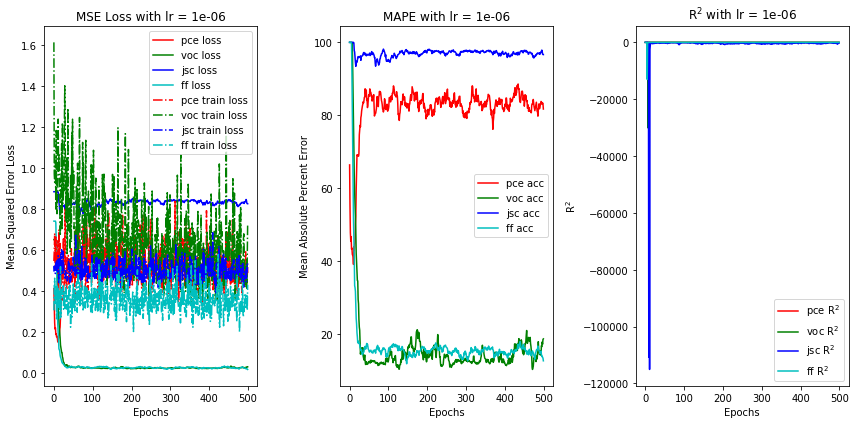

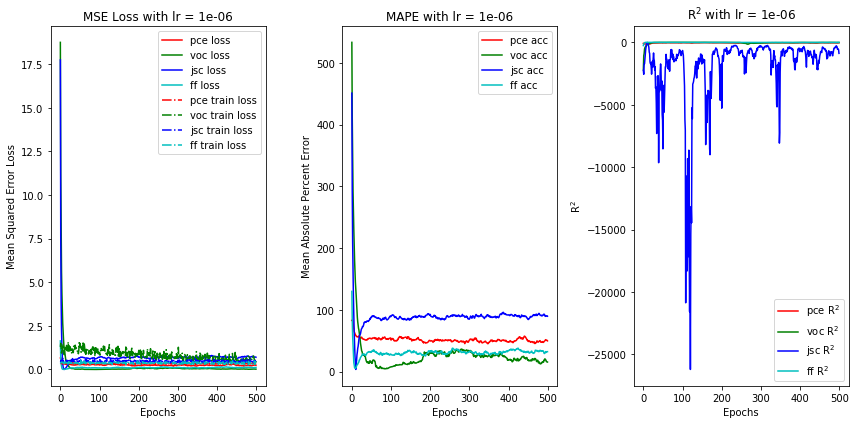

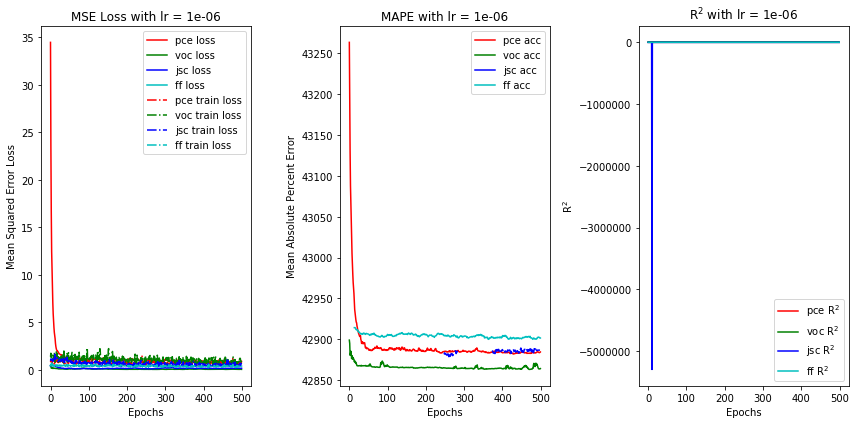

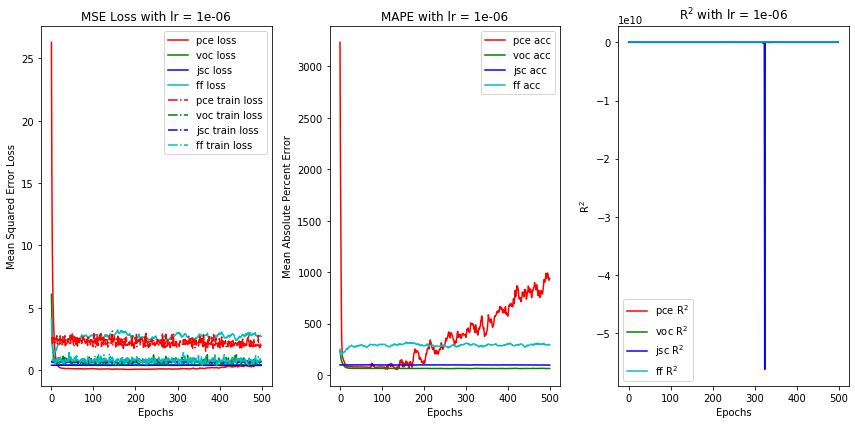

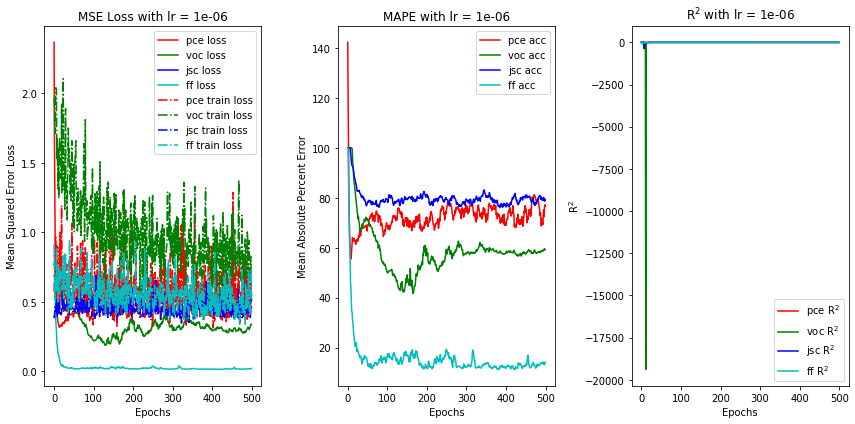

In [74]:
for key, fit_dict in data.items():
    plot_fit_results(fit_dict)